# Importação

In [18]:
import time
import json
import yfinance as yf
import numpy as np
from dataclasses import dataclass
import pandas as pd
from pandas.plotting import scatter_matrix
import aiohttp
import asyncio
import pickle
import sqlite3
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as ts
from scipy.stats import ttest_1samp, gaussian_kde, ttest_ind, percentileofscore, jarque_bera
import scipy.stats as stats
import locale
import math
import struct

locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

'pt_BR.UTF-8'

In [2]:
if "conn" not in globals() or conn is None:
    conn = sqlite3.connect("data/bancoDados.db")
    print("Conexão com o banco de dados criada!")

try:
    # Teste simples para verificar se a conexão está ativa
    conn.execute("SELECT 1")
except sqlite3.ProgrammingError as e:
    print("A conexão com o banco de dados foi fechada, recriando...")
    conn = sqlite3.connect("data/bancoDados.db")

Conexão com o banco de dados criada!


# Modelos de dados:

Utilizado para unificar os tickers das bolsas diferentes

In [3]:
@dataclass
class TickerData:
    ticker_name: str
    sector: str = ""
    sector_key: str = ""
    industry: str = ""
    industry_key: str = ""
    dividend_rate: float = np.nan
    dividend_yield: float = np.nan
    full_exchange_name: str = ""
    ex_dividend_date: str = ""
    payout_ratio: float = np.nan
    beta: float = np.nan
    market_cap: float = np.nan
    price_to_earnings: float = np.nan
    price_to_book: float = np.nan
    return_on_equity: float = np.nan
    free_cashflow: float = np.nan
    incorporation_year: int = None

    yahoo_ticker: yf.Ticker = None
    yahoo_ticker_information: dict = None

    def __post_init__(self):

        if hasattr(self, "_skip_init") and self._skip_init:
            return  # Pula a inicialização automática

        self.yahoo_ticker = yf.Ticker(self.ticker_name)
        self.yahoo_ticker_information = self.yahoo_ticker.info

        self.sector = self.yahoo_ticker_information.get("sector", "N/A")
        self.sector_key = self.yahoo_ticker_information.get("sectorKey", "N/A")
        self.industry = self.yahoo_ticker_information.get("industry", "N/A")
        self.industry_key = self.yahoo_ticker_information.get("industryKey", "N/A")

        self.dividend_rate = self.yahoo_ticker_information.get("dividendRate", np.nan)
        self.dividend_yield = self.yahoo_ticker_information.get("dividendYield", np.nan)
        self.full_exchange_name = self.yahoo_ticker_information.get("fullExchangeName", "N/A")
        self.ex_dividend_date = self.yahoo_ticker_information.get("exDividendDate", "N/A")
        self.payout_ratio = self.yahoo_ticker_information.get("payoutRatio", np.nan)

        self.beta = self.yahoo_ticker_information.get("beta", np.nan)
        self.market_cap = self.yahoo_ticker_information.get("marketCap", np.nan)
        self.price_to_earnings = self.yahoo_ticker_information.get("trailingPE", np.nan)
        self.price_to_book = self.yahoo_ticker_information.get("priceToBook", np.nan)
        self.return_on_equity = self.yahoo_ticker_information.get("returnOnEquity", np.nan)
        self.free_cashflow = self.yahoo_ticker_information.get("freeCashflow", np.nan)

    @classmethod
    def create_without_init(cls, source):
        """
        Cria um objeto TickerData sem rodar o __post_init__.
        O parâmetro `source` pode ser:
        - Um `ticker_name` (str)
        - Um objeto `TickerData`
        - Um dicionário com os mesmos atributos
        """
        if isinstance(source, str):  # Criar com um ticker_name
            obj = cls(source)

        elif isinstance(source, TickerData):  # Copiar de outro objeto TickerData
            obj = cls(**source.__dict__)

        elif isinstance(source, dict):  # Criar a partir de um dicionário
            obj = cls(**source)
            obj.yahoo_ticker = yf.Ticker(obj.ticker_name)

        else:
            raise ValueError("Fonte inválida! Passe um ticker_name (str), um objeto TickerData ou um dicionário.")

        obj._skip_init = True  # Evita que o __post_init__ rode automaticamente
        return obj

# Funções importantes:

In [4]:
def salvar_dict(dicionario, arquivo="dados.pkl"):
    """Salva um dicionário em um arquivo pickle."""
    with open(arquivo, "wb") as f:
        pickle.dump(dicionario, f)
    print(f"✅ Dicionário salvo em {arquivo}")

def carregar_dict(arquivo="dados.pkl"):
    """Carrega um dicionário de um arquivo pickle."""
    try:
        with open(arquivo, "rb") as f:
            dicionario = pickle.load(f)
        print("✅ Dicionário carregado com sucesso!")
        return dicionario
    except FileNotFoundError:
        print("⚠️ Arquivo não encontrado. Retornando um dicionário vazio.")
        return {}


In [5]:
def formatar_numero(numero, decimal_places=0):
    formato = f"%.{decimal_places}f" if decimal_places > 0 else "%d"
    return locale.format_string(formato, numero, grouping=True)

In [6]:
class StdevFunc:
    def __init__(self):
        self.M = 0.0
        self.S = 0.0
        self.k = 1

    def step(self, value):
        if value is None:
            return
        tM = self.M
        self.M += (value - tM) / self.k
        self.S += (value - tM) * (value - self.M)
        self.k += 1

    def finalize(self):
        if self.k < 3:
            return None
        return math.sqrt(self.S / (self.k-2))

# Padronização dos Graficos

In [7]:
def plot_density(
    data: pd.Series,
    title: str = "Gráfico de Distribuição",
    xlabel: str = "Valor",
    ylabel: str = "Densidade",
    figsize: tuple[int, int] = (10, 6)
) -> None:
    """
    Gera um gráfico de densidade para uma Série Pandas.

    Parâmetros:
    - data (pd.Series): Série Pandas contendo os dados numéricos a serem analisados.
    - title (str, opcional): Título do gráfico (padrão: "Gráfico de Distribuição").
    - xlabel (str, opcional): Rótulo do eixo X (padrão: "Valor").
    - ylabel (str, opcional): Rótulo do eixo Y (padrão: "Densidade").
    - figsize (tuple[int, int], opcional): Tamanho da figura em polegadas (padrão: (10, 6)).

    Retorno:
    - None: Exibe o gráfico diretamente.
    """

    # Calcular estatísticas
    media = data.mean()
    desvio_padrao = data.std()

    # Criar a figura e definir a cor de fundo branca
    fig, ax = plt.subplots(figsize=figsize)

    # Criar o gráfico de densidade
    sns.kdeplot(data, fill=True, label="Densidade", linewidth=1.5, ax=ax)

    # Adicionar linhas da média e dos desvios padrão
    ax.axvline(media, color='r', linestyle='dashed', linewidth=1, label=f'Média: {media:.4f}')
    ax.axvline(media, color='black', linestyle='none', linewidth=0, label=f'σ: {desvio_padrao:.4f}')
    ax.axvline(media + desvio_padrao, color='g', linestyle='dashed', linewidth=1, label='- + 1σ')
    ax.axvline(media - desvio_padrao, color='g', linestyle='dashed', linewidth=1)
    ax.axvline(media + 2 * desvio_padrao, color='b', linestyle='dashed', linewidth=1, label='- + 2σ')
    ax.axvline(media - 2 * desvio_padrao, color='b', linestyle='dashed', linewidth=1)
    ax.axvline(media + 3 * desvio_padrao, color='purple', linestyle='dashed', linewidth=1, label='- + 3σ')
    ax.axvline(media - 3 * desvio_padrao, color='purple', linestyle='dashed', linewidth=1)

    # Criar contorno preto nos eixos X e Y (efeito "L")
    ax.axhline(0, color='black', linewidth=1.5)  # Contorno do eixo X
    ax.axvline(media - 4 * desvio_padrao, color='black', linewidth=1.5)  # Contorno do eixo Y

    # Definir os limites do eixo X
    ax.set_xlim(media - 4 * desvio_padrao, media + 4 * desvio_padrao)

    # Configurar rótulos e título
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()

    # Exibir o gráfico
    return plt

# Obtendo os ativos

## NYSE

Feito atraves de um "WebScrapping" da pagina da Nyse

In [8]:
async def fetch_page_NYSE(session, page):
    url = "https://www.nyse.com/api/quotes/filter"
    payload = {
        "instrumentType": "EQUITY",
        "pageNumber": page,
        "sortColumn": "NORMALIZED_TICKER",
        "sortOrder": "ASC",
        "maxResultsPerPage": 10,
        "filterToken": ""
    }
    headers = {
        "Accept": "*/*",
        "Accept-Language": "en-US,en;q=0.9,pt-BR;q=0.8,pt;q=0.7",
        "Content-Type": "application/json",
        "Origin": "https://www.nyse.com",
        "Referer": "https://www.nyse.com/listings_directory/stock",
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Safari/537.36"
    }
    async with session.post(url, json=payload, headers=headers) as response:
        data = await response.json()
        return data

async def fetch_all_assets_NYSE():
    assets = []
    async with aiohttp.ClientSession() as session:
        # Primeiro, colete a primeira página para determinar o total de ativos.
        print("Coletando a primeira página para obter o total de ativos...")
        first_page = await fetch_page_NYSE(session, 1)
        if not first_page:
            print("Falha ao coletar a primeira página.")
            return assets

        # Supondo que o campo "total" esteja presente no primeiro item:
        total_assets = first_page[0].get("total", 0) if first_page and len(first_page) > 0 else 0
        pages = (total_assets // 10) + (1 if total_assets % 10 != 0 else 0)
        print(f"Total de ativos: {total_assets}. Páginas a coletar: {pages}")
        assets.extend(first_page)

        # Loop pelas páginas restantes
        for page in range(2, pages + 1):
            print(f"Coletando página {page}...")
            page_data = await fetch_page_NYSE(session, page)
            assets.extend(page_data)
            print(f"Página {page} coletada com {len(page_data)} ativos.")
            # Aguarde 1 segundo entre as requisições para evitar bloqueios
            await asyncio.sleep(1)

    return assets

all_assets = await fetch_all_assets_NYSE()

Coletando a primeira página para obter o total de ativos...
Total de ativos: 6692. Páginas a coletar: 670
Coletando página 2...
Página 2 coletada com 9 ativos.
Coletando página 3...
Página 3 coletada com 9 ativos.


CancelledError: 

In [ ]:
pd.DataFrame(all_assets).to_csv("data/NYSE_PAPERS.csv")

## NASDAQ

Obtido aqui: https://www.nasdaq.com/market-activity/stocks/screener?page=118&rows_per_page=25

In [ ]:
pd.read_csv("data/NASDAQ_PAPERS.csv")

## Alimentação da tabela "tickers"


In [ ]:
obter_ativos_utilizados = """
SELECT * FROM tickers_ativos
"""

df_tickers_ativos = pd.read_sql(obter_ativos_utilizados, conn)

In [ ]:
todos_tickers: list[TickerData] = []
for  in tqdm(df_tickers_ativos["ticker_name"]):
    todos_tickers.append(TickerData())

In [ ]:
for ticker_row in tqdm(todos_tickers):
    ticker_row.yahoo_ticker = None
    ticker_row.yahoo_ticker_information = str(ticker_row.yahoo_ticker_information)

In [ ]:
df_todos_tickers = pd.DataFrame(todos_tickers)

In [ ]:
df_todos_tickers.drop(["yahoo_ticker"], axis=1, inplace=True)

In [ ]:
df_todos_tickers.to_sql("tickers",conn, if_exists="replace",index=False)

## Tickers de Mercado

In [ ]:
tickers = ['^NYA', '^IXIC']

tickers_mercado = [TickerData(ticker) for ticker in tickers]

In [ ]:
for ticker_row in tqdm(tickers_mercado):
    ticker_row.yahoo_ticker = None
    ticker_row.yahoo_ticker_information = str(ticker_row.yahoo_ticker_information)

In [ ]:
ativos_mercado = pd.DataFrame(tickers_mercado)

In [ ]:
ativos_mercado.to_sql("tickers_mercado",conn, if_exists="replace",index=False)

In [19]:
start_date = "2014-01-01"
tickers_descartados_cotacao = []
tickers_descartados_dividendo = []
tickers_descartados_erro = []

for ticker_row in tqdm(tickers, desc="Processando Tickers"):
    stock = yf.Ticker(ticker_row)
    # Cotações: Verifica se há dados e se cobrem mais de 10 anos
    try:
        prices = stock.history(
                        start=start_date,
                        interval="1d",
                        auto_adjust=False,
                        back_adjust=False,
                        raise_errors=True
        ).reset_index()

        if not prices.empty:
            # Calcula os anos entre a primeira e a última data
            start_year = prices['Date'].iloc[0].year
            end_year = prices['Date'].iloc[-1].year
            years_of_data = end_year - start_year

            # Verifica se há menos de 10 anos de dados
            if years_of_data < 10:
                tickers_descartados_cotacao.append(ticker_row)
                continue

            # Se dados válidos, prossegue com o processamento
            prices['ticker_name'] = ticker_row
            prices.to_sql("prices", conn, if_exists="append", index=False)
        else:
            tickers_descartados_cotacao.append(ticker_row)
            continue

    except Exception as e:
        tickers_descartados_erro.append(ticker_row)
        print(e)
        continue

    time.sleep(0.3)  # Pausa para evitar sobrecarga na API

Processando Tickers: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


# Formalizando os dados

In [ ]:
todos_tickers: list[TickerData] = []
tickers_descartados: list[str] = []

## NYSE

In [ ]:
origem = pd.read_csv("data/NYSE_PAPERS.csv")
total_tickers = len(origem['symbolTicker'])

In [ ]:
realizado = 0
for ticker_row in origem['symbolTicker']:
    print(f"Progresso: {realizado/total_tickers*100:.2f}%")
    try:
        todos_tickers.append(TickerData(ticker_row))
    except Exception as e:
        tickers_descartados.append(ticker_row)
        print(f"Ticker {ticker_row} descartado por motivos de: {str(e)}")
    time.sleep(.5)
    realizado +=1

In [ ]:
copia_todos_tickers = todos_tickers.copy()

for copia_ticker in copia_todos_tickers:
    copia_ticker.yahoo_ticker = ""

dados_tickers = {
    "todos_tickers": todos_tickers,
    "tickers_descartados": tickers_descartados
}

salvar_dict(dados_tickers, "data/dados_tickers_NYSE.pkl")

In [ ]:
teste = todos_tickers[0]
teste.yahoo_ticker = ""
salvar_dict({"teste":teste}, "data/dados_tickers_NYSE.pkl")

### Verificação Posterior

In [ ]:
todos_tickers: pd.DataFrame = origem['symbolTicker']

In [ ]:
original = len(todos_tickers)

In [ ]:
tickers_nyse_list = todos_tickers.to_list()

In [ ]:
placeholders = ', '.join(['(?, "NYSE")'] * len(tickers_nyse_list))  # Gera um (?,?,?) dinâmico
query = f"INSERT INTO tickers_brutos (ticker_name, origem) VALUES {placeholders}"

cursor = conn.cursor()
cursor.execute(query, tickers_nyse_list)

conn.commit()

## NASDAQ

In [ ]:
nasdaq_dados = pd.read_csv("data/NASDAQ_PAPERS.csv")
total_tickers_nasdaq = len(nasdaq_dados['Symbol'])
todos_tickers_nasdaq = []
tickers_descartados_nasdaq = []

In [ ]:
total_tickers_nasdaq

In [ ]:
realizado = 0
for ticker_row in nasdaq_dados['Symbol']:
    print(f"Progresso: {realizado/total_tickers_nasdaq*100:.2f}%")
    try:
        todos_tickers_nasdaq.append(TickerData(ticker_row))
    except Exception as e:
        tickers_descartados_nasdaq.append(ticker_row)
        print(f"Ticker {ticker_row} descartado por motivos de: {str(e)}")
    time.sleep(.5)
    realizado +=1

In [ ]:
copia_todos_tickers = todos_tickers_nasdaq.copy()

for copia_ticker in copia_todos_tickers:
    copia_ticker.yahoo_ticker = ""

dados_tickers_nasdaq = {
    "todos_tickers": todos_tickers_nasdaq,
    "tickers_descartados": tickers_descartados_nasdaq
}

salvar_dict(dados_tickers_nasdaq, "data/dados_tickers_NASDAQ.pkl")

### Verificação Posterior:

In [ ]:
dados_nasdaq_lista = nasdaq_dados['Symbol'].to_list()

In [ ]:
len(dados_nasdaq_lista)

In [ ]:
placeholders = ', '.join(['(?, "NASDAQ")'] * len(dados_nasdaq_lista))  # Gera um (?,?,?) dinâmico
query = f"INSERT INTO tickers_brutos (ticker_name, origem) VALUES {placeholders}"

cursor = conn.cursor()
cursor.execute(query, dados_nasdaq_lista)

conn.commit()

# Banco de dados

## Dados para trabalho

In [ ]:
dados_completos = [*todos_tickers_nasdaq, *todos_tickers]

In [ ]:
df_completa = pd.DataFrame(dados_completos)

In [ ]:
df_completa

In [ ]:
df_completa.replace("N/A", pd.NA, inplace=True)

In [ ]:
# Extract the "ticker_name" list of rows removed due to NA values
removed_tickers = df_completa.loc[df_completa[["sector", "sector_key", "industry"]].isna().any(axis=1), "ticker_name"].tolist()

# Drop rows with NA values in specified columns
df_completa.dropna(subset=["sector", "sector_key", "industry"], inplace=True)

In [ ]:
df_completa["yahoo_ticker_information"] = df_completa["yahoo_ticker_information"].apply(lambda x: json.dumps(x) if isinstance(x, dict) else x)
df_completa.to_sql("tickers", sqlite3.connect("data/bancoDados.db"), if_exists="replace")

In [ ]:
df_completa

## Dados Cortados

In [ ]:
tickers_cortados = [
    *[{"Ticker":f, "Motivo":"Não tinha informação quanto a setor"} for f in removed_tickers],
    *[{"Ticker":g, "Motivo":"Não foi obtido informações, ticker_row da NYSE"} for g in tickers_descartados],
    *[{"Ticker":h, "Motivo":"Não foi obtido informações, ticker_row da NASDAQ"} for h in tickers_descartados_nasdaq]
]

In [ ]:
df_cortada = pd.DataFrame(tickers_cortados)

In [ ]:
df_cortada.to_sql("tickers_cortados", conn, if_exists="replace")

## Obtendo Cotações

In [ ]:
df_tickers = pd.read_sql("""SELECT ticker_name FROM tickers""", conn)

In [ ]:
start_date = "2014-01-01"
tickers_descartados_cotacao = []
tickers_descartados_dividendo = []
tickers_descartados_erro = []

for ticker_row in tqdm(df_tickers['ticker_name'], desc="Processando Tickers"):
    stock = yf.Ticker(ticker_row)
    # Cotações: Verifica se há dados e se cobrem mais de 10 anos
    try:
        prices = stock.history(
                        start=start_date,
                        interval="1d",
                        auto_adjust=False,
                        back_adjust=False,
                        raise_errors=True
        ).reset_index()

        if not prices.empty:
            # Calcula os anos entre a primeira e a última data
            start_year = prices['Date'].iloc[0].year
            end_year = prices['Date'].iloc[-1].year
            years_of_data = end_year - start_year

            # Verifica se há menos de 10 anos de dados
            if years_of_data < 10:
                tickers_descartados_cotacao.append(ticker_row)
                continue

            if not("Dividends" in prices.columns and (prices["Dividends"] > 0).any()):
                tickers_descartados_dividendo.append(ticker_row)
                continue

            # Se dados válidos, prossegue com o processamento
            prices['ticker_name'] = ticker_row
            prices.to_sql("prices", conn, if_exists="append", index=False)
        else:
            tickers_descartados_cotacao.append(ticker_row)
            continue

    except Exception as e:
        tickers_descartados_erro.append(ticker_row)
        print(e)
        continue

    time.sleep(0.3)  # Pausa para evitar sobrecarga na API


In [ ]:
tickers_descartados_df = pd.DataFrame(
   [*[{"Ticker": f, "Motivo":"Erro desconhecido na coleta de cotações" } for f in tickers_descartados_erro],
    *[{"Ticker": f, "Motivo":"Empresa sem Dividendos nos ultimos 10 anos" } for f in tickers_descartados_dividendo],
    *[{"Ticker": f, "Motivo":"Empresa com menos de  10 anos" } for f in tickers_descartados_cotacao]],
    columns=["Ticker", "Motivo"]
)

In [ ]:
tickers_descartados_df.to_sql("tickers_cortados", conn, if_exists="append")

# Verificação dos dados

In [ ]:
def contar_dividendos(ticker: str) -> int:
    """
    Conta quantas vezes foram pagos dividendos para um determinado ticker_row dentro de um período.

    Parâmetros:
    - ticker_row (str): Código do ativo na bolsa (ex: "AAPL").
    - data_inicio (str): Data de início no formato "YYYY-MM-DD".
    - data_fim (str): Data de fim no formato "YYYY-MM-DD".

    Retorna:
    - int: Número de pagamentos de dividendos dentro do período.
    """
    data_inicio = "2014-01-01"
    data_fim = "2025-03-06"
    # Baixa os dados do ativo
    ativo = yf.Ticker(ticker)

    # Obtém o histórico de dividendos
    dividendos = ativo.dividends

    if dividendos.empty:
        print(f"Nenhum dividendo encontrado para {ticker}.")
        return 0

    # Filtra pelo período desejado
    dividendos_periodo = dividendos.loc[data_inicio:data_fim]

    # Retorna a contagem de pagamentos de dividendos
    return len(dividendos_periodo)

In [ ]:
df_verificacao = pd.read_sql("""
SELECT ticker_name, COUNT(*) AS dividend_count
FROM prices
WHERE Dividends != 0
GROUP BY ticker_name
""", conn)

In [ ]:
df_verificacao['Verificacao'] = df_verificacao['ticker_name'].apply(contar_dividendos)

In [ ]:
df_verificacao["Validade"] = df_verificacao['dividend_count'] == df_verificacao['Verificacao']

In [ ]:
df_verificacao

O banco está com todos os dados corretos!

# Processamento

## Plotando numero de dividendos

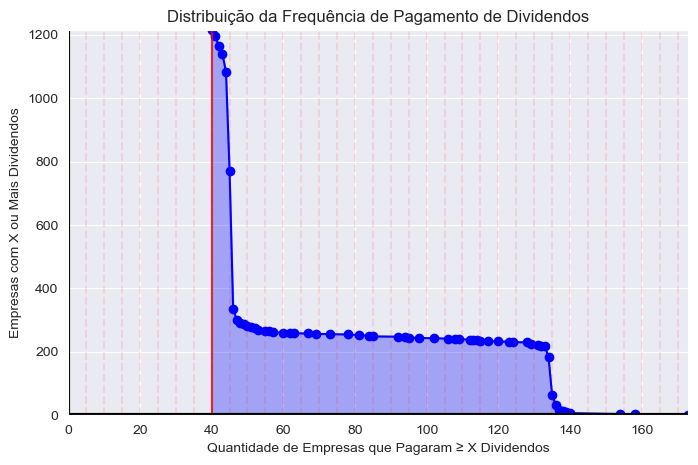

In [7]:
query = """
WITH DividendCounts AS (
    SELECT ticker_name, COUNT(*) AS dividend_count
    FROM prices
    WHERE Dividends != 0
    GROUP BY ticker_name
)
SELECT X, COUNT(*) AS companies_above_X
FROM (
    SELECT DISTINCT dividend_count AS X FROM DividendCounts
) AS Levels
JOIN DividendCounts DC ON DC.dividend_count >= Levels.X
GROUP BY X
ORDER BY X;
"""

# Conectar ao banco e executar a query
df = pd.read_sql_query(query, conn)

# Criar o gráfico de densidade invertida
plt.figure(figsize=(8, 5))
plt.fill_between(df["X"], df["companies_above_X"], color='blue', alpha=0.3)
plt.plot(df["X"], df["companies_above_X"], marker='o', linestyle='-', color='blue')
plt.axvline(x=40, color='red', linestyle='-', alpha=0.8)
plt.xlim(0, df["X"].max())
plt.ylim(0,df['companies_above_X'].max())
# Configurar labels e título
plt.xlabel("Quantidade de Empresas que Pagaram ≥ X Dividendos")
plt.ylabel("Empresas com X ou Mais Dividendos")
plt.title("Distribuição da Frequência de Pagamento de Dividendos")
for x in range(0, df["X"].max() + 1, 5):
    plt.axvline(x, color='red', linestyle='--', alpha=0.1)

plt.axhline(y=0, color='black', linewidth=3)  # Linha horizontal no eixo X
plt.axvline(x=0, color='black', linewidth=3)  # Linha vertical no eixo Y começando no X=1


# Mostrar o gráfico
plt.show()

In [ ]:
df['Percentual'] = df['companies_above_X'] / 2030 * 100

In [ ]:
df

In [ ]:
df.to_excel("Saidas/CompaniasComDividendos.xlsx", index=False)

## Testes com Betas

In [9]:
query_lista_ativos = """
select DISTINCT(ticker_name)
from prices;
"""

In [10]:
cursor = None
try:
    cursor = conn.cursor()
    cursor.execute(query_lista_ativos)
    lista_ativos_bruta = cursor.fetchall()
    lista_ativos = [ativo[0] for ativo in lista_ativos_bruta]
    print(lista_ativos[0:5])
finally:
    # Garantir o fechamento do cursor
    cursor.close()


['A', 'AAP', 'AAPL', 'AAT', 'ABBV']


## Teste Individual

In [8]:
query_cotacoes = """
SELECT *
FROM prices
WHERE ticker_name = :ticker_name
ORDER BY Date asc;
"""

In [ ]:
try:
    del df, df_dividends
except:
    pass

In [ ]:
params = {"ticker_name": "AAPL"}  # Substitua "AAPL" pelo ticker_row que deseja filtrar
df = pd.read_sql_query(query_cotacoes, conn, params=params)

In [ ]:
# Remover o fuso horário ANTES de converter para datetime
df['Date'] = df['Date'].astype(str).str[:-6]  # Remove o "-04:00" ou qualquer fuso
df['Date'] = pd.to_datetime(df['Date'])  # Agora converte sem erro
df = df.sort_values('Date')

In [ ]:
# Criar uma coluna com o Open do dia anterior (no df original)
df["Close_Previous_Day"] = df["Close"].shift(1)

df['R'] = df['Open'] / df['Close_Previous_Day'] - 1

# Filtrar os dias onde houve pagamento de dividendos
df_dividends = df[df["Dividends"] != 0].copy()

# Calcular a variação relativa ao montante distribuído
df_dividends["Price_Drop_Per_Dividend"] = (df_dividends["Close_Previous_Day"] - df_dividends["Open"]) / df_dividends["Dividends"]



In [ ]:
df_dividends = df_dividends.dropna(subset=["Price_Drop_Per_Dividend"])

# Calcular estatísticas
media = df_dividends["Price_Drop_Per_Dividend"].mean()
desvio_padrao = df_dividends["Price_Drop_Per_Dividend"].std()

# Criar o gráfico de densidade
plt.figure(figsize=(10, 6))
sns.kdeplot(df_dividends["Price_Drop_Per_Dividend"], fill=True, label="Densidade")

# Adicionar linhas da média e do desvio padrão
plt.axvline(media, color='r', linestyle='dashed', linewidth=2, label=f'Média: {media:.4f}')
plt.axvline(media + desvio_padrao, color='g', linestyle='dashed', linewidth=2, label=f'+1σ: {desvio_padrao:.4f}')
plt.axvline(media - desvio_padrao, color='g', linestyle='dashed', linewidth=2, label=f'-1σ')

# Configurar rótulos e título
plt.xlabel("Price Drop Per Dividend")
plt.ylabel("Density")
plt.title("Distribuição da Queda do Preço Relativa ao Dividendo")
plt.legend()

# Exibir o gráfico
plt.show()

In [ ]:
# Criar a figura e o eixo principal (esquerda)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotar a série "Price_Drop_Per_Dividend" no eixo da esquerda
ax1.plot(df_dividends["Date"], df_dividends["Price_Drop_Per_Dividend"],
         color='b', marker='o', linestyle='-', label="Price Drop Per Dividend")
ax1.set_xlabel("Data")
ax1.set_ylabel("Price Drop Per Dividend", color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Criar o segundo eixo (direita) para "Dividends"
ax2 = ax1.twinx()
ax2.plot(df_dividends["Date"], df_dividends["Dividends"],
         color='r', marker='s', linestyle='--', label="Dividendo Distribuído")
ax2.set_ylabel("Dividendo Distribuído", color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Melhorando o layout
fig.tight_layout()
plt.title("Evolução do Price Drop Per Dividend, Dividendo Distribuído e Preço da Ação")

# Exibir o gráfico
plt.show()

In [ ]:
# Criar a figura e o eixo principal (esquerda)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotar a série "Price_Drop_Per_Dividend" no eixo da esquerda
ax1.plot(df_dividends["Date"], df_dividends["Price_Drop_Per_Dividend"],
         color='b',  linestyle='-', label="Price Drop Per Dividend")
ax1.set_xlabel("Data")
ax1.set_ylabel("Price Drop Per Dividend", color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Criar o segundo eixo (direita) para "Dividends"
ax2 = ax1.twinx()
ax2.plot(df_dividends["Date"], df_dividends["Dividends"],
         color='r', linestyle='--', label="Dividendo Distribuído")
ax2.set_ylabel("Dividendo Distribuído", color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Criar um terceiro eixo para o preço da ação
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Deslocar para evitar sobreposição
ax3.plot(df["Date"], df["Close"], color='g', linestyle='-', label="Preço de Fechamento")
ax3.set_ylabel("Preço de Fechamento", color='g')
ax3.tick_params(axis='y', labelcolor='g')

# Melhorando o layout
fig.tight_layout()
plt.title("Evolução do Price Drop Per Dividend, Dividendo Distribuído, Preço da Ação e Volume")

# Exibir o gráfico
plt.show()

In [ ]:
# Criar a figura e o eixo principal (esquerda)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotar a série "Price_Drop_Per_Dividend" no eixo da esquerda
ax1.plot(df_dividends["Date"], df_dividends["Price_Drop_Per_Dividend"],
         color='b',  linestyle='-', label="Price Drop Per Dividend")
ax1.set_xlabel("Data")
ax1.set_ylabel("Price Drop Per Dividend", color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Criar o segundo eixo (direita) para "Dividends"
ax2 = ax1.twinx()
ax2.plot(df_dividends["Date"], df_dividends["Dividends"],
         color='r', linestyle='--', label="Dividendo Distribuído")
ax2.set_ylabel("Dividendo Distribuído", color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Criar um terceiro eixo para o volume negociado
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Deslocar para evitar sobreposição
ax3.bar(df["Date"], df["Volume"], color='g', alpha=0.3, label="Volume Negociado")
ax3.set_ylabel("Volume Negociado", color='g')
ax3.tick_params(axis='y', labelcolor='g')

# Melhorando o layout
fig.tight_layout()
plt.title("Evolução do Price Drop Per Dividend, Dividendo Distribuído e Volume Negociado")

# Exibir o gráfico
plt.show()

In [ ]:
# Calcular o desvio padrão móvel de 30 dias do preço de fechamento
df["Std_Close"] = df["Close"].rolling(window=30).std()

# Criar a figura e o eixo principal (esquerda)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotar a série "Price Drop Per Dividend" no eixo da esquerda
ax1.plot(df_dividends["Date"], df_dividends["Price_Drop_Per_Dividend"],
         color='b', linestyle='-', label="Price Drop Per Dividend")
ax1.set_xlabel("Data")
ax1.set_ylabel("Price Drop Per Dividend", color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Criar o segundo eixo (direita) para "Dividends"
ax2 = ax1.twinx()
ax2.plot(df_dividends["Date"], df_dividends["Dividends"],
         color='r', linestyle='--', label="Dividendo Distribuído")
ax2.set_ylabel("Dividendo Distribuído", color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Criar um terceiro eixo para o desvio padrão do preço da ação
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Deslocar para evitar sobreposição
ax3.plot(df["Date"], df["Std_Close"], color='g', linestyle='-', label="Desvio Padrão (30 dias)")
ax3.set_ylabel("Desvio Padrão do Preço (30 dias)", color='g')
ax3.tick_params(axis='y', labelcolor='g')

# Melhorando o layout
fig.tight_layout()
plt.title("Evolução do Price Drop Per Dividend, Dividendo Distribuído e Desvio Padrão do Preço da Ação")

# Exibir o gráfico
plt.show()

In [ ]:
# Criar a figura e o eixo principal (esquerda)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotar a série "Price Drop Per Dividend" no eixo da esquerda
ax1.plot(df_dividends["Date"], df_dividends["Price_Drop_Per_Dividend"],
         color='b', linestyle='-', label="Price Drop Per Dividend")
ax1.set_xlabel("Data")
ax1.set_ylabel("Price Drop Per Dividend", color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Criar o segundo eixo (direita) para "Dividends"
ax2 = ax1.twinx()
ax2.plot(df_dividends["Date"], df_dividends["Dividends"],
         color='r', linestyle='--', label="Dividendo Distribuído")
ax2.set_ylabel("Dividendo Distribuído", color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Criar um terceiro eixo para "R", substituindo o desvio padrão
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Deslocar para evitar sobreposição
ax3.plot(df["Date"], df["R"], color='g', linestyle='-', label="R")
ax3.set_ylabel("R", color='g')
ax3.tick_params(axis='y', labelcolor='g')

# Melhorando o layout
fig.tight_layout()
plt.title("Evolução do Price Drop Per Dividend, Dividendo Distribuído e R")

# Exibir o gráfico
plt.show()

In [ ]:
# Calcular estatísticas
media_r = df["R"].mean()
desvio_padrao_r = df["R"].std()
contagem_r = len(df['R'])

# Criar o gráfico de densidade
plt.figure(figsize=(10, 6))
sns.kdeplot(df["R"], fill=True, label="Densidade")

# Adicionar linhas da média e do desvio padrão
plt.axvline(media_r, color='r', linestyle='dashed', linewidth=2, label=f'Média: {media_r:.4f}')
plt.axvline(media_r + desvio_padrao_r, color='g', linestyle='dashed', linewidth=2, label=f'+1σ: {desvio_padrao_r:.4f}')
plt.axvline(media_r - desvio_padrao_r, color='g', linestyle='dashed', linewidth=2, label=f'-1σ')

# Configurar rótulos e título
plt.xlabel("R")
plt.ylabel("Density")
plt.title(f"Distribuição de R, amostra {contagem_r}")
plt.legend()

# Exibir o gráfico
plt.show()


In [ ]:
# Calcular estatísticas
media_r_filtered = df_dividends["R"].mean()
desvio_padrao_r_filtered = df_dividends["R"].std()
contagem = len(df_dividends["R"])

# Criar o gráfico de densidade
plt.figure(figsize=(10, 6))
sns.kdeplot(df_dividends["R"], fill=True, label="Densidade")

# Adicionar linhas da média e do desvio padrão
plt.axvline(media_r_filtered, color='r', linestyle='dashed', linewidth=2, label=f'Média: {media_r_filtered:.4f}')
plt.axvline(media_r_filtered + desvio_padrao_r_filtered, color='g', linestyle='dashed', linewidth=2, label=f'+1σ: {desvio_padrao_r_filtered:.4f}')
plt.axvline(media_r_filtered - desvio_padrao_r_filtered, color='g', linestyle='dashed', linewidth=2, label=f'-1σ')

# Configurar rótulos e título
plt.xlabel("R")
plt.ylabel("Density")
plt.title(f"Distribuição de R (Apenas quando Dividends ≠ 0) Amostra: {contagem}")
plt.legend()

# Exibir o gráfico
plt.show()

In [ ]:
# Calcular estatísticas
df_filtered = df[df['Dividends'] == 0].copy()

media_r_filtered = df_filtered["R"].mean()
desvio_padrao_r_filtered = df_filtered["R"].std()
contagem = len(df_filtered["R"])

# Criar o gráfico de densidade
plt.figure(figsize=(10, 6))
sns.kdeplot(df_filtered["R"], fill=True, label="Densidade")

# Adicionar linhas da média e do desvio padrão
plt.axvline(media_r_filtered, color='r', linestyle='dashed', linewidth=2, label=f'Média: {media_r_filtered:.4f}')
plt.axvline(media_r_filtered + desvio_padrao_r_filtered, color='g', linestyle='dashed', linewidth=2, label=f'+1σ: {desvio_padrao_r_filtered:.4f}')
plt.axvline(media_r_filtered - desvio_padrao_r_filtered, color='g', linestyle='dashed', linewidth=2, label=f'-1σ')

# Configurar rótulos e título
plt.xlabel("R")
plt.ylabel("Density")
plt.title(f"Distribuição de R (Apenas quando Dividends = 0) Amostra: {contagem}")
plt.legend()

# Exibir o gráfico
plt.show()

In [ ]:
# testes para verificar se são a mesma distribuição:
R_global = df["R"].dropna()
R_divs = df_dividends["R"].dropna()
R_sem_divs = df_filtered["R"].dropna()


comparisons = {
    ("R_global", "R_divs"): stats.ks_2samp(R_global, R_divs),
    ("R_global", "R_sem_divs"): stats.ks_2samp(R_global, R_sem_divs),
    ("R_divs", "R_sem_divs"): stats.ks_2samp(R_divs, R_sem_divs),
}

alpha = 0.05
# Criando a matriz de resultados
results_matrix = pd.DataFrame(index=["R_global", "R_divs", "R_sem_divs"],
                              columns=["R_global", "R_divs", "R_sem_divs"])

# Preenchendo a matriz com "Diferente" ou "Igual" conforme o valor-p do teste KS
for (r1, r2), (statistic, p_value) in comparisons.items():
    results_matrix.loc[r1, r2] = p_value
    results_matrix.loc[r2, r1] = p_value  # Para manter simetria

# Diagonal é sempre "Igual", pois está comparando a mesma distribuição
np.fill_diagonal(results_matrix.values, 1)

results_matrix

In [ ]:
shapiro_stat, shapiro_p = stats.shapiro(R_divs)

# Teste de Mann-Whitney U para comparar R_divs com os outros dois grupos
mw_global_stat, mw_global_p = stats.mannwhitneyu(R_global, R_divs, alternative='two-sided')
mw_sem_divs_stat, mw_sem_divs_p = stats.mannwhitneyu(R_sem_divs, R_divs, alternative='two-sided')

# Criando tabela com os resultados
test_results = pd.DataFrame({
    "Teste": ["Shapiro-Wilk (Normalidade R_divs)",
              "Mann-Whitney U (R_global vs R_divs)",
              "Mann-Whitney U (R_sem_divs vs R_divs)"],
    "Estatística": [shapiro_stat, mw_global_stat, mw_sem_divs_stat],
    "p-valor": [shapiro_p, mw_global_p, mw_sem_divs_p],
    "Conclusão (alpha=0.05)": ["Rejeita H0 (Não Normal)" if shapiro_p < 0.05 else "Aceita H0 (Normal)",
                                "Diferente" if mw_global_p < 0.05 else "Igual",
                                "Diferente" if mw_sem_divs_p < 0.05 else "Igual"]
})
test_results

## Aplicando Testes em larga escala

In [ ]:
for ativo in tqdm(lista_ativos):
    params = {"ticker_name": ativo}  # Substitua "AAPL" pelo ticker_row que deseja filtrar
    df = pd.read_sql_query(query_cotacoes, conn, params=params)

    # Remover o fuso horário ANTES de converter para datetime
    df['Date'] = df['Date'].astype(str).str[:-6]  # Remove o "-04:00" ou qualquer fuso
    df['Date'] = pd.to_datetime(df['Date'])  # Agora converte sem erro
    df = df.sort_values('Date')

    # Criar uma coluna com o Open do dia anterior (no df original)
    df["Close_Previous_Day"] = df["Close"].shift(1)

    # Filtrar os dias onde houve pagamento de dividendos
    df_dividends = df[df["Dividends"] != 0].copy()

    # Calcular a variação relativa ao montante distribuído
    df_dividends["Price_Drop_Per_Dividend"] = (df_dividends["Close_Previous_Day"] - df_dividends["Open"]) / df_dividends["Dividends"]

    cursor = conn.cursor()

    # Selecionar apenas as colunas necessárias
    df_to_insert = df_dividends[['Date', 'ticker_name', 'Price_Drop_Per_Dividend']].copy()

    # Renomear colunas para coincidir com a tabela SQL
    df_to_insert.rename(columns={'Price_Drop_Per_Dividend': 'value'}, inplace=True)

    # Inserir no SQLite (modo append)
    df_to_insert.to_sql('pre_test_dividends', conn, if_exists='append', index=False)

    cursor.close()


In [ ]:
query_pre_test_dividends = """
SELECT *
FROM pre_test_dividends
"""

In [ ]:
df_pre_test_dividends = pd.read_sql_query(query_pre_test_dividends, conn)
df_pre_test_dividends['Date'] = pd.to_datetime(df_pre_test_dividends['Date'])

In [ ]:
# Definindo os percentis desejados
percentiles = [0, 1, 2.5, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 97.5, 99, 100]
df_pre_test_dividends_clean = df_pre_test_dividends.dropna()

# Calculando os valores estatísticos
desc_stats = df_pre_test_dividends_clean['value'].describe()
percentile_values = np.percentile(df_pre_test_dividends_clean['value'], percentiles)
# Criando um DataFrame consolidado
stats_df = pd.DataFrame({'Metric': ['count', 'mean', 'std'] + [f'{p}%' for p in percentiles],
                         'Value': list(desc_stats)[:3] + list(percentile_values)})
stats_df.to_excel("Saidas/StatsPreTestDividends.xlsx", index=False)

In [ ]:
df_pre_test_dividends = df_pre_test_dividends.dropna(subset=["value"])

# Filtrar os valores extremos no intervalo de -10 a 10
df_pre_test_dividends = df_pre_test_dividends[(df_pre_test_dividends["value"] >= -10) & (df_pre_test_dividends["value"] <= 10)]

# Calcular estatísticas
media = df_pre_test_dividends["value"].mean()
desvio_padrao = df_pre_test_dividends["value"].std()

# Criar o gráfico de densidade
plt.figure(figsize=(10, 6))
sns.kdeplot(df_pre_test_dividends["value"], fill=True, label="Densidade", bw_adjust=1.2)

# Adicionar linhas da média e do desvio padrão
plt.axvline(media, color='r', linestyle='dashed', linewidth=2, label=f'Média: {media:.4f}')
plt.axvline(media + desvio_padrao, color='g', linestyle='dashed', linewidth=2, label=f'+1σ: {desvio_padrao:.4f}')
plt.axvline(media - desvio_padrao, color='g', linestyle='dashed', linewidth=2, label=f'-1σ')

# Configurar rótulos e título
plt.xlabel("Price Drop Per Dividend global")
plt.ylabel("Density")
plt.xlim(-10, 10)  # Limitar ao intervalo de -10 a 10
plt.title("Distribuição da Queda do Preço Relativa ao Dividendo")
plt.legend()

# Exibir o gráfico
plt.show()

In [ ]:
# Agrupar os dados por semana para reduzir o ruído
df_weekly = df_pre_test_dividends.groupby(pd.Grouper(key='Date', freq='W'))['value'] \
                                  .agg(['mean', 'std']).reset_index()

# Plot dos dados: primeiro a linha do desvio padrão e depois a linha da média (para que fique por cima)
plt.figure(figsize=(12, 6))
plt.plot(df_weekly['Date'], df_weekly['mean'] + df_weekly['std'], color='blue', linestyle='--', linewidth=2, label='Desvio Padrão', zorder=3)
plt.plot(df_weekly['Date'], df_weekly['mean'], color='red', linewidth=2, label='Média', zorder=5)
plt.plot(df_weekly['Date'], df_weekly['mean'] - df_weekly['std'], color='blue', linestyle='--', linewidth=2, label='Desvio Padrão', zorder=3)

plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Tendência da Média e Desvio Padrão (Agrupados Semanalmente)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Retorno Aftermarket

In [9]:
query_r_sem_dividendos = """
with cotacoes AS (
    SELECT ticker_name,
         Date,
         Open,
         Close,
         Dividends,
         LAG(Close, 1) OVER (PARTITION BY ticker_name ORDER BY Date) AS fechamento_ontem
    FROM prices
)
SELECT *, (c.Open / c.fechamento_ontem) - 1  as Diff
FROM cotacoes as c
where
    fechamento_ontem IS NOT NULL
    AND Dividends == 0;
"""

In [10]:
df_r_global = pd.read_sql(query_r_sem_dividendos, conn)

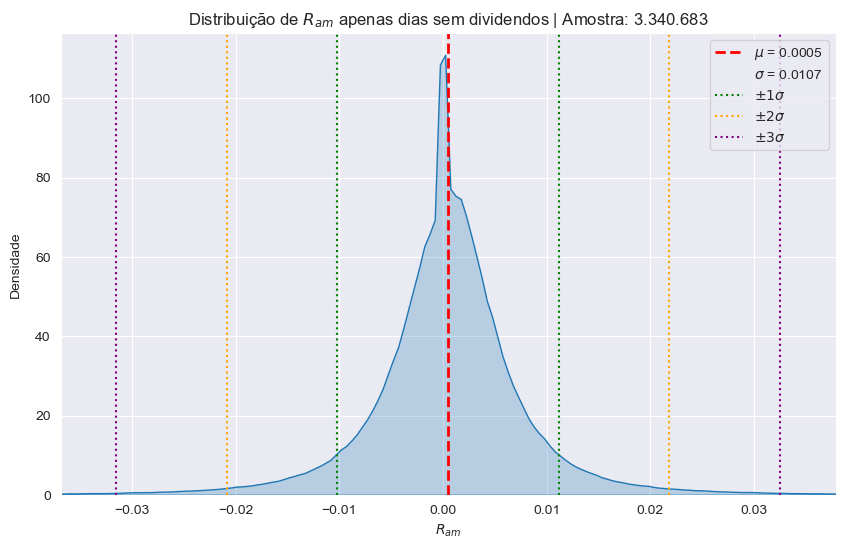

In [27]:
# Calcular estatísticas
df_filtered = df_r_global.copy()

media_r_filtered = df_filtered["Diff"].mean()
desvio_padrao_r_filtered = df_filtered["Diff"].std()
contagem = len(df_filtered["Diff"])

# Criar o gráfico de densidade
plt.figure(figsize=(10, 6))
sns.kdeplot(df_filtered["Diff"], fill=True, bw_adjust=0.4, clip=(-0.05, 0.05))

# Linha da média
plt.axvline(media_r_filtered, color='red', linestyle='dashed', linewidth=2,
            label=rf"$\mu$ = {media_r_filtered:.4f}")

# Linha de σ (sem deslocamento, apenas para legenda simbólica)
plt.plot([], [], color='none', linestyle='solid', linewidth=1.5,
         label=r"$\sigma$ = {:.4f}".format(desvio_padrao_r_filtered))

# Adicionar linhas para ±1σ, ±2σ, ±3σ com cores distintas
cores = ['green', 'orange', 'purple']
for i, cor in zip([1, 2, 3], cores):
    plt.axvline(media_r_filtered + i * desvio_padrao_r_filtered, color=cor, linestyle='dotted', linewidth=1.5)
    plt.axvline(media_r_filtered - i * desvio_padrao_r_filtered, color=cor, linestyle='dotted', linewidth=1.5)
    plt.plot([], [], color=cor, linestyle='dotted', linewidth=1.5, label=fr"$\pm{i}\sigma$")

# Ajustar limites
plt.xlim(media_r_filtered - 3.5 * desvio_padrao_r_filtered, media_r_filtered + 3.5 * desvio_padrao_r_filtered)

# Rótulos e título
plt.xlabel(r"$R_{am}$")
plt.ylabel("Densidade")
plt.title(fr"Distribuição de $R_{{am}}$ apenas dias sem dividendos | Amostra: {contagem:,.0f}".replace(",", "."))

# Legenda ordenada no canto superior direito
plt.legend(loc="upper right")

# Mostrar o gráfico
plt.show()

In [28]:
# Supondo que df_filtered["Diff"] já esteja definido
media = df_filtered["Diff"].mean()
desvio = df_filtered["Diff"].std()
n = len(df_filtered["Diff"])

# Estatística Z
z = media / (desvio / np.sqrt(n))
p_valor = 2 * (1 - stats.norm.cdf(abs(z)))

print(f"Z = {z:.4f}, p-valor = {p_valor:.10f}")

Z = 82.4241, p-valor = 0.0000000000


In [29]:
d = media / desvio
print(f"Cohen's d: {d:.4f}")


Cohen's d: 0.0451


In [30]:
query_r_com_dividendos = """
with cotacoes AS (
    SELECT ticker_name,
         Date,
         Open,
         Close,
         Dividends,
         LAG(Close, 1) OVER (PARTITION BY ticker_name ORDER BY Date) AS fechamento_ontem
    FROM prices
)
SELECT *, (c.Open / c.fechamento_ontem) - 1  as Diff
FROM cotacoes as c
where
    fechamento_ontem IS NOT NULL
    AND Dividends != 0;
"""

df_r_global_div = pd.read_sql(query_r_com_dividendos, conn)

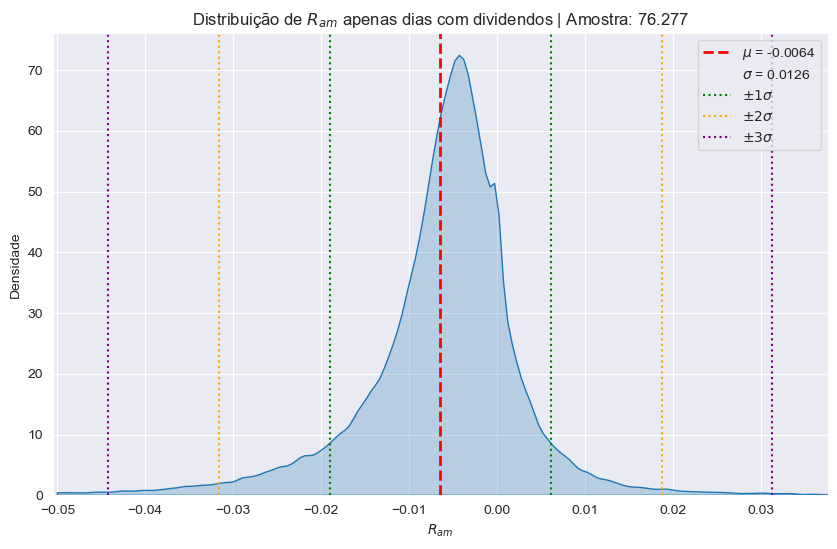

In [33]:
# Calcular estatísticas
df_filtered_div = df_r_global_div.copy()

media_r_filtered = df_filtered_div["Diff"].mean()
desvio_padrao_r_filtered = df_filtered_div["Diff"].std()
contagem = len(df_filtered_div["Diff"])

# Criar o gráfico de densidade
plt.figure(figsize=(10, 6))
sns.kdeplot(df_filtered_div["Diff"], fill=True, bw_adjust=0.4, clip=(-0.05, 0.05))

# Linha da média
plt.axvline(media_r_filtered, color='red', linestyle='dashed', linewidth=2,
            label=rf"$\mu$ = {media_r_filtered:.4f}")

# Linha de σ (sem deslocamento, apenas para legenda simbólica)
plt.plot([], [], color='none', linestyle='solid', linewidth=1.5,
         label=r"$\sigma$ = {:.4f}".format(desvio_padrao_r_filtered))

# Adicionar linhas para ±1σ, ±2σ, ±3σ com cores distintas
cores = ['green', 'orange', 'purple']
for i, cor in zip([1, 2, 3], cores):
    plt.axvline(media_r_filtered + i * desvio_padrao_r_filtered, color=cor, linestyle='dotted', linewidth=1.5)
    plt.axvline(media_r_filtered - i * desvio_padrao_r_filtered, color=cor, linestyle='dotted', linewidth=1.5)
    plt.plot([], [], color=cor, linestyle='dotted', linewidth=1.5, label=fr"$\pm{i}\sigma$")

# Ajustar limites
plt.xlim(media_r_filtered - 3.5 * desvio_padrao_r_filtered, media_r_filtered + 3.5 * desvio_padrao_r_filtered)

# Rótulos e título
plt.xlabel(r"$R_{am}$")
plt.ylabel("Densidade")
plt.title(fr"Distribuição de $R_{{am}}$ apenas dias com dividendos | Amostra: {contagem:,.0f}".replace(",", "."))

# Legenda ordenada no canto superior direito
plt.legend(loc="upper right")

# Mostrar o gráfico
plt.show()


In [36]:
# Supondo que df_filtered["Diff"] já esteja definido
media = df_filtered_div["Diff"].mean()
desvio = df_filtered_div["Diff"].std()
n = len(df_filtered_div["Diff"])

# Estatística Z
z = media / (desvio / np.sqrt(n))
p_valor = 2 * (1 - stats.norm.cdf(abs(z)))

print(f"Z = {z:.4f}, p-valor = {p_valor:.10f}")

d = media / desvio
print(f"Cohen's d: {d:.4f}")


Z = -141.0718, p-valor = 0.0000000000
Cohen's d: -0.5108


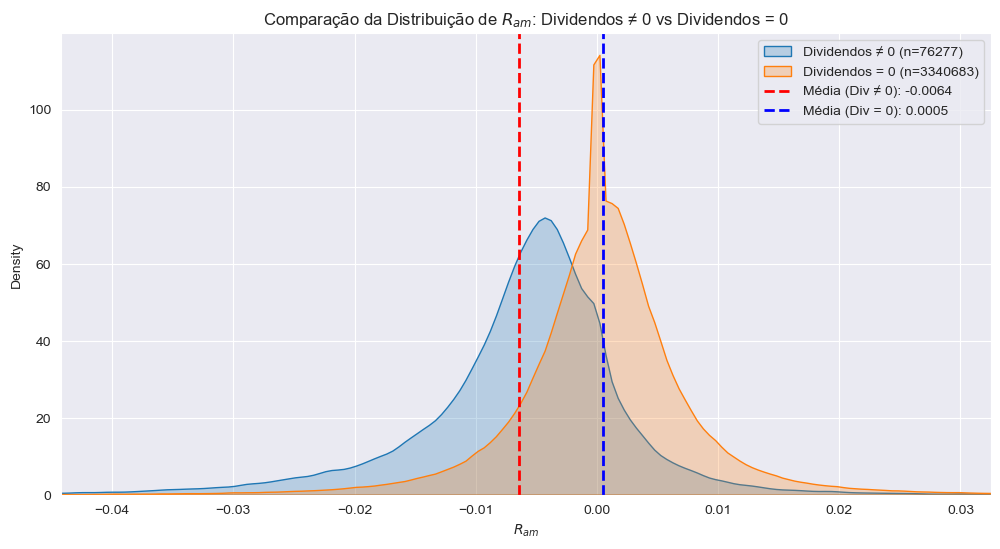

In [39]:
# Calcular estatísticas para Dividendos != 0
df_filtered_div = df_r_global_div.copy()
media_r_div = df_filtered_div["Diff"].mean()
desvio_padrao_r_div = df_filtered_div["Diff"].std()
contagem_div = len(df_filtered_div["Diff"])

# Calcular estatísticas para Dividendos = 0
df_filtered = df_r_global.copy()
media_r = df_filtered["Diff"].mean()
desvio_padrao_r = df_filtered["Diff"].std()
contagem = len(df_filtered["Diff"])

# Criar os gráficos de densidade lado a lado para comparação
plt.figure(figsize=(12, 6))

sns.kdeplot(df_filtered_div["Diff"], fill=True, label=f"Dividendos ≠ 0 (n={contagem_div})", bw_adjust=0.5, clip=(-0.05, 0.05))
sns.kdeplot(df_filtered["Diff"], fill=True, label=f"Dividendos = 0 (n={contagem})", bw_adjust=0.5, clip=(-0.05, 0.05))

# Adicionar linhas das médias
plt.axvline(media_r_div, color='r', linestyle='dashed', linewidth=2, label=f'Média (Div ≠ 0): {media_r_div:.4f}')
plt.axvline(media_r, color='b', linestyle='dashed', linewidth=2, label=f'Média (Div = 0): {media_r:.4f}')

# Ajustar limites dos eixos
xmin = min(media_r_div - 3*desvio_padrao_r_div, media_r - 3*desvio_padrao_r)
xmax = max(media_r_div + 3*desvio_padrao_r_div, media_r + 3*desvio_padrao_r)
plt.xlim(xmin, xmax)

# Configurar rótulos e título
plt.xlabel(r"$R_{am}$")
plt.ylabel("Density")
plt.title("Comparação da Distribuição de $R_{am}$: Dividendos ≠ 0 vs Dividendos = 0")
plt.legend()

# Exibir o gráfico
plt.show()

## Testes quanto ao R

### o sem dividendo é um ruido branco?

In [ ]:
def testar_ruido_branco_ticker(ticker, conn, query, significance=0.05, lag=10):
    """
    Testa se a série de tempo de uma companhia (coluna "Diff") é ruído branco.

    Critérios testados:
      1. Média zero (teste t de uma amostra);
      2. Variância constante (teste ARCH);
      3. Ausência de autocorrelação (Ljung-Box e Box-Pierce);
      4. Autocorrelação de primeira ordem (teste Durbin-Watson);
      5. Estacionaridade (teste Augmented Dickey-Fuller).

    Parâmetros:
      - ticker_row: (str) nome do ativo.
      - conn: conexão com o banco de dados.
      - query: query SQL que aceita um parâmetro para o ticker_row.
      - significance: nível de significância para os testes (default 0.05).
      - lag: número de lags para os testes.

    Retorna:
      Um dicionário com os resultados e as decisões de cada teste, incluindo uma decisão global.
    """

    result_dict = {"ticker_row": ticker}

    # Busca os dados para o ticker_row
    try:
        df_company = pd.read_sql(query, conn, params=[ticker])
    except Exception as e:
        result_dict["error"] = f"Erro na consulta: {e}"
        return result_dict

    # Verifica se a coluna "Diff" existe
    if "Diff" not in df_company.columns:
        result_dict["error"] = "Coluna 'Diff' não encontrada"
        return result_dict

    diff = df_company["Diff"].dropna()

    # Verifica se há dados suficientes para os testes
    if len(diff) < lag:
        result_dict["error"] = "Dados insuficientes"
        return result_dict

    # 1. Teste de média zero (teste t de uma amostra)
    t_stat, t_pvalue = ttest_1samp(diff, popmean=0)
    result_dict["mean_stat"] = t_stat
    result_dict["mean_pvalue"] = t_pvalue
    result_dict["mean_decision"] = "ruido branco" if t_pvalue > significance else "não ruido branco"

    # 2. Teste de variância constante (homocedasticidade) – Teste ARCH
    arch_stat, arch_pvalue, arch_f, arch_f_pvalue = het_arch(diff, nlags=lag)
    result_dict["arch_stat"] = arch_stat
    result_dict["arch_pvalue"] = arch_pvalue
    result_dict["arch_decision"] = "ruido branco" if arch_pvalue > significance else "não ruido branco"

    # 3. Testes de autocorrelação – Ljung-Box e Box-Pierce
    lb_result = acorr_ljungbox(diff, lags=[lag], return_df=True, boxpierce=True)
    lb_stat = lb_result["lb_stat"].iloc[-1]
    lb_pvalue = lb_result["lb_pvalue"].iloc[-1]
    bp_stat = lb_result["bp_stat"].iloc[-1]
    bp_pvalue = lb_result["bp_pvalue"].iloc[-1]
    result_dict["lb_stat"] = lb_stat
    result_dict["lb_pvalue"] = lb_pvalue
    result_dict["bp_stat"] = bp_stat
    result_dict["bp_pvalue"] = bp_pvalue
    result_dict["acorr_decision"] = "ruido branco" if (lb_pvalue > significance and bp_pvalue > significance) else "não ruido branco"

    # 4. Teste Durbin-Watson (autocorrelação de primeira ordem)
    dw_stat = durbin_watson(diff)
    result_dict["dw_stat"] = dw_stat
    # Considera "ruido branco" se o valor estiver aproximadamente em 2 (ex.: entre 1.5 e 2.5)
    result_dict["dw_decision"] = "ruido branco" if 1.5 < dw_stat < 2.5 else "não ruido branco"

    # 5. Teste de estacionaridade – Augmented Dickey-Fuller
    adf_result = adfuller(diff, autolag='AIC', maxlag=lag)
    adf_stat, adf_pvalue, usedlag, nobs, crit_values, icbest = adf_result
    result_dict["adf_stat"] = adf_stat
    result_dict["adf_pvalue"] = adf_pvalue
    # Se p-valor < significance, rejeita a hipótese nula de raiz unitária (ou seja, é estacionária)
    result_dict["adf_decision"] = "ruido branco" if adf_pvalue < significance else "não ruido branco"

    # Decisão global: somente se TODOS os testes indicarem ruido branco
    if (result_dict["mean_decision"]=="ruido branco" and
        result_dict["arch_decision"]=="ruido branco" and
        result_dict["acorr_decision"]=="ruido branco" and
        result_dict["dw_decision"]=="ruido branco" and
        result_dict["adf_decision"]=="ruido branco"):
        overall = "ruido branco"
    else:
        overall = "não ruido branco"
    result_dict["overall_decision"] = overall

    return result_dict


In [ ]:
query_r_ticker = """
with cotacoes AS (
    SELECT ticker_name,
         Date,
         Open,
         Close,
         Dividends,
         LAG(Close, 1) OVER (PARTITION BY ticker_name ORDER BY Date) AS fechamento_ontem
    FROM prices
)
SELECT *, (c.Open / c.fechamento_ontem) - 1  as Diff
FROM cotacoes as c
where
    fechamento_ontem IS NOT NULL
    AND Dividends == 0 AND
    ticker_name == ?;
"""

query_tickers = """
SELECT
    DISTINCT ticker_name
FROM prices;
"""

In [ ]:
df_tickers = pd.read_sql(query_tickers, conn)

In [ ]:
df_tickers_result = df_tickers.copy()

In [ ]:
df_tickers_result = df_tickers_result['ticker_name'].apply(
    lambda t: pd.Series(testar_ruido_branco_ticker(t, conn, query_r_com_dividendos))
)

In [ ]:
df_results_ruido = pd.DataFrame()
criterios = ["mean_decision", "arch_decision", "acorr_decision", "dw_decision", "adf_decision", "overall_decision"]
for crit in criterios:
    df_results_ruido[crit] = df_tickers_result[crit].value_counts()

df_results_ruido = df_results_ruido.T
df_results_ruido.columns.name = "Decisões"

In [ ]:
df_results_ruido

#### `mean_decision` - Teste de Média Zero
Verifica se a média da série é estatisticamente zero. Se não for, pode indicar tendência (drift).

#### `arch_decision` - Teste ARCH (Heterocedasticidade)
Testa se a variância da série é constante ao longo do tempo. Se variar, a volatilidade não é estável.

#### `acorr_decision` - Teste de Autocorrelação
Usa Ljung-Box e Box-Pierce para verificar dependência temporal. Se houver, a série tem memória.

#### `dw_decision` - Teste de Durbin-Watson
Avalia autocorrelação de primeira ordem. Valores próximos de 2 indicam ausência de dependência.

#### `adf_decision` - Teste ADF (Estacionaridade)
Verifica se a série tem raiz unitária. Se rejeitar a hipótese nula, a série é estacionária.

#### `overall_decision` - Decisão Final
A série só é ruído branco se passar em todos os testes. Se falhar em algum, tem padrão detectável.


In [ ]:
df_tickers_result.describe()

In [ ]:
# Dados
data_mean = df_tickers_result['mean_pvalue'].dropna().values
density_mean = gaussian_kde(data_mean)
x_mean = np.linspace(0, 1, 1000)
y_mean = density_mean(x_mean)
y_max_mean = y_mean.max()

# Configuração do gráfico
plt.figure(figsize=(10, 6))
sns.kdeplot(data_mean, fill=True, color='blue')

# Linhas e Regiões Críticas
plt.axvline(0.05, color='black', linestyle='--', linewidth=1.5, label='Valor Crítico = 0.05')
plt.axvspan(0, 0.05, color='red', alpha=0.3, label='Rejeita H0 (p < 0.05) → Indica Tendência (Drift)')
plt.axvspan(0.05, 1, color='green', alpha=0.2, label='Aceita H0 (p ≥ 0.05) → Sem Tendência')

# Rótulos e Estilização
plt.xlim(0, 1)
plt.ylim(0, y_max_mean * 1.1)
plt.title("Teste de Média Zero\nVerificação de Tendência (Drift) na Série Temporal", fontsize=14)
plt.xlabel("P-Valor", fontsize=12)
plt.ylabel("Densidade", fontsize=12)

# Explicação das Hipóteses
plt.text(0.15, y_max_mean * 0.9, "H0: A média da série é estatisticamente zero\n→ Não há tendência detectável", fontsize=11, color='black')
plt.text(0.15, y_max_mean * 0.8, "H1: A média da série NÃO é zero\n→ Existe tendência (drift)", fontsize=11, color='black')

plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [ ]:
# Dados
data_arch = df_tickers_result['arch_pvalue'].dropna().values
density_arch = gaussian_kde(data_arch)
x_arch = np.linspace(0, 1, 1000)
y_arch = density_arch(x_arch)
y_max_arch = y_arch.max()

# Configuração do gráfico
plt.figure(figsize=(10, 6))
sns.kdeplot(data_arch, fill=True, color='blue')

# Linhas e Regiões Críticas
plt.axvline(0.05, color='black', linestyle='--', linewidth=1.5, label='Valor Crítico = 0.05')
plt.axvspan(0, 0.05, color='red', alpha=0.3, label='Rejeita H0 (p < 0.05) → Variância NÃO é constante')
plt.axvspan(0.05, 1, color='green', alpha=0.2, label='Aceita H0 (p ≥ 0.05) → Variância constante')

# Rótulos e Estilização
plt.xlim(0, 1)
plt.ylim(0, y_max_arch * 1.1)
plt.title("Teste ARCH - Heterocedasticidade\nVerificação da Estabilidade da Variância", fontsize=14)
plt.xlabel("P-Valor", fontsize=12)
plt.ylabel("Densidade", fontsize=12)

# Explicação das Hipóteses
plt.text(0.15, y_max_arch * 0.9, "H0: A variância da série é constante\n→ Volatilidade estável", fontsize=11, color='black')
plt.text(0.15, y_max_arch * 0.8, "H1: A variância da série NÃO é constante\n→ Volatilidade instável (Heterocedasticidade)", fontsize=11, color='black')

plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [ ]:
# Dados
data_lb = df_tickers_result['lb_pvalue'].dropna().values
density_lb = gaussian_kde(data_lb)
x_lb = np.linspace(0, 1, 1000)
y_lb = density_lb(x_lb)
y_max_lb = y_lb.max()

# Configuração do gráfico
plt.figure(figsize=(10, 6))
sns.kdeplot(data_lb, fill=True, color='blue')

# Linhas e Regiões Críticas
plt.axvline(0.05, color='black', linestyle='--', linewidth=1.5, label='Valor Crítico = 0.05')
plt.axvspan(0, 0.05, color='red', alpha=0.3, label='Rejeita H0 (p < 0.05) → Existe autocorrelação')
plt.axvspan(0.05, 1, color='green', alpha=0.2, label='Aceita H0 (p ≥ 0.05) → Sem autocorrelação')

# Rótulos e Estilização
plt.xlim(0, 1)
plt.ylim(0, y_max_lb * 1.1)
plt.title("Teste de Autocorrelação - Ljung-Box\nVerificação de Dependência Temporal", fontsize=14)
plt.xlabel("P-Valor", fontsize=12)
plt.ylabel("Densidade", fontsize=12)

# Explicação das Hipóteses
plt.text(0.15, y_max_lb * 0.9, "H0: A série NÃO tem autocorrelação\n→ Valores independentes ao longo do tempo", fontsize=11, color='black')
plt.text(0.15, y_max_lb * 0.8, "H1: A série TEM autocorrelação\n→ Existe dependência temporal (memória)", fontsize=11, color='black')

plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [ ]:
data_bp = df_tickers_result['bp_pvalue'].dropna().values
density_bp = gaussian_kde(data_bp)
x_bp = np.linspace(0, 1, 1000)
y_bp = density_bp(x_bp)
y_max_bp = y_bp.max()

# Configuração do gráfico
plt.figure(figsize=(10, 6))
sns.kdeplot(data_bp, fill=True, color='blue')

# Linhas e Regiões Críticas
plt.axvline(0.05, color='black', linestyle='--', linewidth=1.5, label='Valor Crítico = 0.05')
plt.axvspan(0, 0.05, color='red', alpha=0.3, label='Rejeita H0 (p < 0.05) → Existe autocorrelação')
plt.axvspan(0.05, 1, color='green', alpha=0.2, label='Aceita H0 (p ≥ 0.05) → Sem autocorrelação')

# Rótulos e Estilização
plt.xlim(0, 1)
plt.ylim(0, y_max_bp * 1.1)
plt.title("Teste de Autocorrelação - Box-Pierce\nVerificação de Dependência Temporal", fontsize=14)
plt.xlabel("P-Valor", fontsize=12)
plt.ylabel("Densidade", fontsize=12)

# Explicação das Hipóteses
plt.text(0.15, y_max_bp * 0.9, "H0: A série NÃO tem autocorrelação\n→ Valores independentes ao longo do tempo", fontsize=11, color='black')
plt.text(0.15, y_max_bp * 0.8, "H1: A série TEM autocorrelação\n→ Existe dependência temporal (memória)", fontsize=11, color='black')

plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [ ]:
# Dados
data_adf = df_tickers_result['adf_pvalue'].dropna().values

# Aplicando jitter para espalhar os dados (pequena variação aleatória)
jitter_strength = 0.02  # Ajuste fino para não distorcer os dados
data_adf_jittered = np.clip(data_adf + np.random.uniform(-jitter_strength, jitter_strength, len(data_adf)), 0, 1)

# Estimando densidade
density_adf = gaussian_kde(data_adf_jittered, bw_method=0.2)  # Aumenta a suavização
x_adf = np.linspace(0, 1, 1000)
y_adf = density_adf(x_adf)
y_max_adf = y_adf.max()

# Configuração do gráfico
plt.figure(figsize=(10, 6))

# Plot KDE e histograma
sns.histplot(data_adf_jittered, bins=30, kde=False, color="lightgray", alpha=0.6, label="Histograma")
sns.kdeplot(data_adf_jittered, fill=True, color='blue', linewidth=2, bw_adjust=0.5)

# Linhas e Regiões Críticas
plt.axvline(0.05, color='black', linestyle='--', linewidth=1.5, label='Valor Crítico = 0.05')
plt.axvspan(0, 0.05, color='red', alpha=0.3, label='Rejeita H0 (p < 0.05) → Série Estacionária')
plt.axvspan(0.05, 1, color='green', alpha=0.2, label='Aceita H0 (p ≥ 0.05) → Série NÃO Estacionária')

# Rótulos e Estilização
plt.xlim(0, 1)
plt.ylim(0, y_max_adf * 1.2)
plt.title("Teste ADF - Estacionaridade\nVerificação da Raiz Unitária na Série Temporal", fontsize=14)
plt.xlabel("P-Valor", fontsize=12)
plt.ylabel("Densidade", fontsize=12)

# Explicação das Hipóteses
plt.text(0.15, y_max_adf * 0.9, "H0: A série TEM raiz unitária\n→ NÃO é estacionária", fontsize=11, color='black')
plt.text(0.15, y_max_adf * 0.8, "H1: A série NÃO tem raiz unitária\n→ É estacionária", fontsize=11, color='black')

plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [ ]:
# df_tickers_result.to_sql("analise_ruido", conn, if_exists="append")

## Aprimoramento do beta

### Beta Regressão

In [8]:
query_cotacoes_por_ativo = """
with cotacoes AS (
    SELECT
        ticker_name,
         Date,
         Open,
         Close,
         Dividends,
         LAG(Close, 1) OVER (PARTITION BY ticker_name ORDER BY Date) AS fechamento_ontem
    FROM prices
)
SELECT *
FROM cotacoes as c
where
    fechamento_ontem IS NOT NULL AND
    ticker_name == ?;
"""

def regressao_dividendos(ticker_name):
    """
    Roda a regressão para um ativo específico e retorna os principais indicadores em um dicionário.

    Parâmetros:
    - ticker_name (str): Código do ativo.
    - conn: Conexão com o banco de dados.

    Retorna:
    - dict com coeficientes, métricas de ajuste, testes estatísticos e detecção de outliers.
    """

    # Consulta os dados do ativo
    query = """
    with cotacoes AS (
        SELECT
             ticker_name,
             Date,
             Open,
             Close,
             Dividends,
             LAG(Close, 1) OVER (PARTITION BY ticker_name ORDER BY Date) AS fechamento_ontem
        FROM prices
    )
    SELECT *
    FROM cotacoes as c
    where
        fechamento_ontem IS NOT NULL AND
        ticker_name == ? AND
        Dividends != 0;
    """
    df = pd.read_sql(query, conn, params=[ticker_name])

    # # Filtra apenas os dias com dividendos
    # df = df[df["Dividends"] != 0]

    # Variável dependente: retorno ajustado
    y_ajustado = df["Open"] - df["fechamento_ontem"]

    # Variável independente: dividendos + constante
    X = df[["Dividends"]]
    X = sm.add_constant(X)

    # Regressão OLS
    modelo = sm.OLS(y_ajustado, X).fit()

    # Influência e diagnóstico de outliers
    influence = modelo.get_influence()
    cooks_d = influence.cooks_distance[0]
    max_cooks = np.max(cooks_d)
    indice_outlier = int(np.argmax(cooks_d))
    outlier_flag = max_cooks > 4 / len(df)

    # Teste de normalidade dos resíduos
    jb_stat, jb_p = jarque_bera(modelo.resid)

    # Durbin-Watson para autocorrelação dos resíduos
    durbin = sm.stats.stattools.durbin_watson(modelo.resid)

    # Percentis dos resíduos
    residuos = modelo.resid
    p2_5 = np.percentile(residuos, 2.5)
    p25 = np.percentile(residuos, 25)
    p50 = np.percentile(residuos, 50)
    p75 = np.percentile(residuos, 75)
    p97_5 = np.percentile(residuos, 97.5)
    extremos = np.sum((residuos < p2_5) | (residuos > p97_5))

    # Resultados principais
    resultados = {
        "ticker_name": ticker_name,
        "alfa": modelo.params["const"] if "const" in modelo.params else None,
        "beta_dividendo": modelo.params["Dividends"],
        "erro_alfa": modelo.bse["const"] if "const" in modelo.params else None,
        "erro_beta": modelo.bse["Dividends"],
        "significancia_alfa": modelo.pvalues["const"] if "const" in modelo.params else None,
        "significancia_beta": modelo.pvalues["Dividends"],
        "r2": modelo.rsquared,
        "r2_ajustado": modelo.rsquared_adj,
        "f_stat": modelo.fvalue,
        "p_f_stat": modelo.f_pvalue,
        "durbin_watson": durbin,
        "jarque_bera": jb_stat,
        "p_jarque_bera": jb_p,
        "max_cooks_distance": max_cooks,
        "indice_outlier": indice_outlier,
        "possui_outlier_influente": outlier_flag,
        "residuo_p2_5": p2_5,
        "residuo_p25": p25,
        "residuo_p50": p50,
        "residuo_p75": p75,
        "residuo_p97_5": p97_5,
        "quantidade_residuos_extremos": int(extremos),
        "resumo": modelo.summary().as_text()
    }

    return resultados

In [10]:
query_tickers = """
SELECT *
from tickers_ativos
"""
df_tickers = pd.read_sql(query_tickers, conn)

In [11]:
df_resultados = df_tickers["ticker_name"].apply(lambda x: regressao_dividendos(x))
df_resultados = pd.DataFrame.from_records(df_resultados)

C:\Users\diogo\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:847: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
C:\Users\diogo\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:847: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
C:\Users\diogo\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:847: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


In [14]:
# df_resultados.to_sql("beta_dividendo_bruto", conn, if_exists="replace", index=False)

1214

In [ ]:
colunas_numericas = df_resultados.select_dtypes(include='number').columns[:24]

# Cria o pairplot em resolução alta
plot = sns.pairplot(df_resultados[colunas_numericas], corner=True, plot_kws={"alpha": 0.5})

# Ajusta título e layout
plot.fig.suptitle("Matriz de Dispersão - Todas contra todas", fontsize=22)
plot.fig.subplots_adjust(top=0.97)  # Deixa espaço pro título

# Salva como imagem em alta resolução
plot.fig.set_size_inches(40, 40)  # Tamanho grande para qualidade 4K+
plot.fig.savefig("para_tcc/matriz_dispersao_24x24.png", dpi=300)


# Analise Beta de Dividendo - da base de dados

## Beta dividendo regressão mercado


In [6]:
def regressao_dividendos_global():
    """
    Roda a regressão para um ativo específico e retorna os principais indicadores em um dicionário.

    Parâmetros:
    - ticker_name (str): Código do ativo.
    - conn: Conexão com o banco de dados.

    Retorna:
    - dict com coeficientes, métricas de ajuste, testes estatísticos e detecção de outliers.
    """

    # Consulta os dados do ativo
    query = """
    with cotacoes AS (
        SELECT
             ticker_name,
             Date,
             Open,
             Close,
             Dividends,
             LAG(Close, 1) OVER (PARTITION BY ticker_name ORDER BY Date) AS fechamento_ontem
        FROM prices
    )
    SELECT *
    FROM cotacoes as c
    where
        fechamento_ontem IS NOT NULL AND
        Dividends != 0 and
        ticker_name IN (SELECT ticker_name from tickers_ativos);
    """
    df = pd.read_sql(query, conn)

    # # Filtra apenas os dias com dividendos
    # df = df[df["Dividends"] != 0]

    # Variável dependente: retorno ajustado
    y_ajustado = df["Open"] - df["fechamento_ontem"]

    # Variável independente: dividendos + constante
    X = df[["Dividends"]]
    X = sm.add_constant(X)

    # Regressão OLS
    modelo = sm.OLS(y_ajustado, X).fit()

    # Influência e diagnóstico de outliers
    influence = modelo.get_influence()
    cooks_d = influence.cooks_distance[0]
    max_cooks = np.max(cooks_d)
    indice_outlier = int(np.argmax(cooks_d))
    outlier_flag = max_cooks > 4 / len(df)

    # Teste de normalidade dos resíduos
    jb_stat, jb_p = jarque_bera(modelo.resid)

    # Durbin-Watson para autocorrelação dos resíduos
    durbin = sm.stats.stattools.durbin_watson(modelo.resid)

    # Percentis dos resíduos
    residuos = modelo.resid
    p2_5 = np.percentile(residuos, 2.5)
    p25 = np.percentile(residuos, 25)
    p50 = np.percentile(residuos, 50)
    p75 = np.percentile(residuos, 75)
    p97_5 = np.percentile(residuos, 97.5)
    extremos = np.sum((residuos < p2_5) | (residuos > p97_5))

    # Resultados principais
    resultados = {
        "ticker_name": "Global",
        "alfa": modelo.params["const"] if "const" in modelo.params else None,
        "beta_dividendo": modelo.params["Dividends"],
        "erro_alfa": modelo.bse["const"] if "const" in modelo.params else None,
        "erro_beta": modelo.bse["Dividends"],
        "significancia_alfa": modelo.pvalues["const"] if "const" in modelo.params else None,
        "significancia_beta": modelo.pvalues["Dividends"],
        "r2": modelo.rsquared,
        "r2_ajustado": modelo.rsquared_adj,
        "f_stat": modelo.fvalue,
        "p_f_stat": modelo.f_pvalue,
        "durbin_watson": durbin,
        "jarque_bera": jb_stat,
        "p_jarque_bera": jb_p,
        "max_cooks_distance": max_cooks,
        "indice_outlier": indice_outlier,
        "possui_outlier_influente": outlier_flag,
        "residuo_p2_5": p2_5,
        "residuo_p25": p25,
        "residuo_p50": p50,
        "residuo_p75": p75,
        "residuo_p97_5": p97_5,
        "quantidade_residuos_extremos": int(extremos),
        "resumo": modelo.summary().as_text()
    }

    return resultados

In [7]:
reg_div_global = regressao_dividendos_global()

In [9]:
print(reg_div_global['resumo'])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                 3.692e+04
Date:                seg, 21 abr 2025   Prob (F-statistic):               0.00
Time:                        15:43:09   Log-Likelihood:                -87505.
No. Observations:               76277   AIC:                         1.750e+05
Df Residuals:                   76275   BIC:                         1.750e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0205      0.003      6.770      0.0

In [12]:
exchanges_nasdaq = ["NasdaqGS", "NasdaqCM", "NasdaqGM"]
exchanges_nyse = ["NYSE","NYSE American"]

In [10]:
def calcular_beta_por_mercado(exchanges_list, nome_grupo):
    # Cria placeholders para o número de exchanges
    placeholders = ','.join(['?'] * len(exchanges_list))

    query = f"""
    WITH cotacoes AS (
        SELECT
            ticker_name,
            Date,
            Open,
            Close,
            Dividends,
            LAG(Close, 1) OVER (PARTITION BY ticker_name ORDER BY Date) AS fechamento_ontem
        FROM prices
    )
    SELECT c.*
    FROM cotacoes AS c
    INNER JOIN tickers t
        ON c.ticker_name = t.ticker_name
    WHERE
        fechamento_ontem IS NOT NULL AND
        Dividends != 0 AND
        t.full_exchange_name IN ({placeholders});
    """

    df = pd.read_sql(query, conn, params=exchanges_list)

    if df.empty:
        return {"ticker_name": nome_grupo, "erro": "Nenhum dado encontrado para esse mercado."}

    y_ajustado = df["Open"] - df["fechamento_ontem"]
    X = sm.add_constant(df[["Dividends"]])

    modelo = sm.OLS(y_ajustado, X).fit()

    influence = modelo.get_influence()
    cooks_d = influence.cooks_distance[0]
    max_cooks = np.max(cooks_d)
    indice_outlier = int(np.argmax(cooks_d))
    outlier_flag = max_cooks > 4 / len(df)

    jb_stat, jb_p = jarque_bera(modelo.resid)
    durbin = sm.stats.stattools.durbin_watson(modelo.resid)

    residuos = modelo.resid
    p2_5 = np.percentile(residuos, 2.5)
    p25 = np.percentile(residuos, 25)
    p50 = np.percentile(residuos, 50)
    p75 = np.percentile(residuos, 75)
    p97_5 = np.percentile(residuos, 97.5)
    extremos = np.sum((residuos < p2_5) | (residuos > p97_5))

    resultados = {
        "ticker_name": nome_grupo,
        "alfa": modelo.params.get("const"),
        "beta_dividendo": modelo.params["Dividends"],
        "erro_alfa": modelo.bse.get("const"),
        "erro_beta": modelo.bse["Dividends"],
        "significancia_alfa": modelo.pvalues.get("const"),
        "significancia_beta": modelo.pvalues["Dividends"],
        "r2": modelo.rsquared,
        "r2_ajustado": modelo.rsquared_adj,
        "f_stat": modelo.fvalue,
        "p_f_stat": modelo.f_pvalue,
        "durbin_watson": durbin,
        "jarque_bera": jb_stat,
        "p_jarque_bera": jb_p,
        "max_cooks_distance": max_cooks,
        "indice_outlier": indice_outlier,
        "possui_outlier_influente": outlier_flag,
        "residuo_p2_5": p2_5,
        "residuo_p25": p25,
        "residuo_p50": p50,
        "residuo_p75": p75,
        "residuo_p97_5": p97_5,
        "quantidade_residuos_extremos": int(extremos),
        "resumo": modelo.summary().as_text()
    }

    return resultados


In [31]:
beta_nasdaq = calcular_beta_por_mercado(exchanges_nasdaq, "NASDAQ")
beta_nyse = calcular_beta_por_mercado(exchanges_nyse, "NYSE")

In [32]:
print(beta_nyse['resumo'])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                 2.001e+04
Date:                seg, 21 abr 2025   Prob (F-statistic):               0.00
Time:                        16:39:17   Log-Likelihood:                -62961.
No. Observations:               60448   AIC:                         1.259e+05
Df Residuals:                   60446   BIC:                         1.259e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0086      0.003      2.682      0.0

In [30]:
print(beta_nasdaq['resumo'])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                 1.201e+04
Date:                seg, 21 abr 2025   Prob (F-statistic):               0.00
Time:                        16:00:08   Log-Likelihood:                -22427.
No. Observations:               15789   AIC:                         4.486e+04
Df Residuals:                   15787   BIC:                         4.487e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0454      0.008      5.420      0.0

In [20]:
beta_nasdaqGS = calcular_beta_por_mercado(["NasdaqGS"], "NASDAQ_GS")
beta_nasdaqCM = calcular_beta_por_mercado(["NasdaqCM"], "NASDAQ_CM")
beta_nasdaqGM = calcular_beta_por_mercado(["NasdaqGM"], "NASDAQ_GM")

In [24]:
print(beta_nasdaqGS['resumo'])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                 1.104e+04
Date:                seg, 21 abr 2025   Prob (F-statistic):               0.00
Time:                        16:11:14   Log-Likelihood:                -20619.
No. Observations:               14091   AIC:                         4.124e+04
Df Residuals:                   14089   BIC:                         4.126e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0523      0.009      5.643      0.0

In [25]:
print(beta_nasdaqGM['resumo'])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     171.7
Date:                seg, 21 abr 2025   Prob (F-statistic):           7.51e-37
Time:                        16:11:34   Log-Likelihood:                -932.32
No. Observations:                1252   AIC:                             1869.
Df Residuals:                    1250   BIC:                             1879.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0575      0.015     -3.800      0.0

In [26]:
print(beta_nasdaqCM['resumo'])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     156.7
Date:                seg, 21 abr 2025   Prob (F-statistic):           5.37e-31
Time:                        16:11:24   Log-Likelihood:                 48.972
No. Observations:                 446   AIC:                            -93.94
Df Residuals:                     444   BIC:                            -85.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.015     -0.134      0.8

In [33]:
beta_nyse_only = calcular_beta_por_mercado(["NYSE"], "NYSE")
beta_nyseAmerican = calcular_beta_por_mercado(["NYSE American"], "NYSE American")

In [34]:
print(beta_nyse_only['resumo'])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                 1.977e+04
Date:                seg, 21 abr 2025   Prob (F-statistic):               0.00
Time:                        16:39:50   Log-Likelihood:                -62547.
No. Observations:               59822   AIC:                         1.251e+05
Df Residuals:                   59820   BIC:                         1.251e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0087      0.003      2.684      0.0

In [29]:
print(beta_nyseAmerican['resumo'])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     341.2
Date:                seg, 21 abr 2025   Prob (F-statistic):           4.25e-61
Time:                        16:33:14   Log-Likelihood:                -201.02
No. Observations:                 626   AIC:                             406.0
Df Residuals:                     624   BIC:                             414.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.016     -0.091      0.9

## Analises Globais

In [3]:
df_resultados = pd.read_sql("SELECT * FROM beta_dividendo_bruto", conn)

In [4]:
def tratar_binario(val):
    if isinstance(val, bytes):
        try:
            unpacked = struct.unpack('d', val)[0]
            if unpacked == float('inf'):
                return float('inf')
            else:
                return unpacked
        except:
            return np.nan
    return val  # já é float

In [5]:
df_resultados["p_f_stat"] = df_resultados["p_f_stat"].apply(tratar_binario)
df_resultados["p_f_stat"] = df_resultados["p_f_stat"].astype("float64")

## Analise Alfa

In [57]:
analise_alfa = df_resultados[['ticker_name','alfa','erro_alfa','significancia_alfa']]

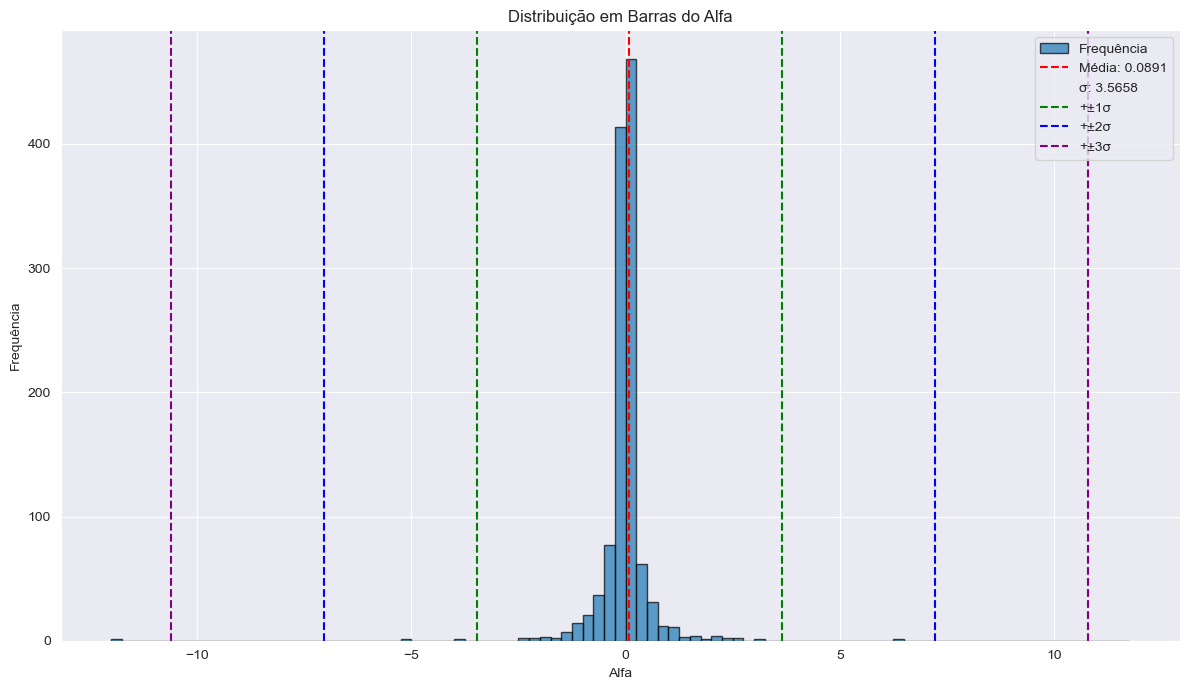

In [64]:
# Parâmetros
dados = analise_alfa['alfa']

media = dados.mean()
desvio = dados.std()

min = int(media + -3.5 *desvio)
max = int(media + 3.5 *desvio)
bins = np.arange(min,max, 0.25)

# Plot
plt.figure(figsize=(12, 7))
plt.hist(dados, bins=bins, edgecolor='black', alpha=0.7, label='Frequência')

# Linhas de referência
plt.axvline(media, color='red', linestyle='--', label=f'Média: {media:.4f}')
plt.axvline(media, color='black', linestyle='none', linewidth=0, label=f'σ: {desvio:.4f}')
for i, color, label in zip([1, 2, 3], ['green', 'blue', 'purple'], [r'±1σ', r'±2σ', r'±3σ']):
    plt.axvline(media + i * desvio, color=color, linestyle='--', label=f'+{label}')
    plt.axvline(media - i * desvio, color=color, linestyle='--')

# Título e legenda
plt.title('Distribuição em Barras do Alfa')
plt.xlabel('Alfa')
plt.ylabel('Frequência')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [75]:
dados = analise_alfa['alfa']
significancia = analise_alfa['significancia_alfa']

# Define os limites de significância
limiares = [0.05, 0.10, 0.15,1]
index = 0
tabela_resultado = []

for limite in limiares:
    filtro = significancia <= limite
    if index > 0:
        filtro = (significancia <= limite) & (significancia > limiares[index-1])
    subset = dados[filtro]
    stats = subset.describe()

    tabela_resultado.append({
        'Limite Significância': f'{int(limiares[index-1]*100) if index > 0 else 0}% <= {int(limite*100)}%',
        'Contagem': len(subset),
        'Média': stats['mean'],
        'Mediana': stats['50%'],
        'Desvio Padrão': stats['std'],
        'Mínimo': stats['min'],
        'Máximo': stats['max']
    })
    index += 1

pd.DataFrame(tabela_resultado)

,Limite Significância,Contagem,Média,Mediana,Desvio Padrão,Mínimo,Máximo
0,0% <= 5%,86,-0.042611,0.014354,2.232296,-11.906381,15.920294
1,5% <= 10%,52,-0.044239,-0.017271,0.680195,-2.382022,2.094120
2,10% <= 15%,68,1.831907,0.037370,14.570333,-3.937303,119.868318
3,15% <= 100%,980,-0.013205,0.000351,0.425674,-5.229796,3.157715


In [76]:
df = df_resultados[['ticker_name','alfa','erro_alfa','significancia_alfa']].copy()

# Distância padronizada de alfa ao zero
df['distancia_padronizada'] = abs(df['alfa'] / df['erro_alfa'])

# Estatísticas descritivas
resumo_distancia = df['distancia_padronizada'].describe(percentiles=[.25, .5, .75, .95, .99])

In [77]:
resumo_distancia

count    1186.000000
mean        0.868665
std         0.903573
min         0.000303
25%         0.296536
50%         0.653449
75%         1.204696
95%         2.248984
99%         3.557160
max        14.533154
Name: distancia_padronizada, dtype: float64

## Analise R2

In [23]:
df_resultados

,ticker_name,alfa,beta_dividendo,erro_alfa,erro_beta,significancia_alfa,significancia_beta,r2,r2_ajustado,f_stat,...,max_cooks_distance,indice_outlier,possui_outlier_influente,residuo_p2_5,residuo_p25,residuo_p50,residuo_p75,residuo_p97_5,quantidade_residuos_extremos,resumo
0,A,0.135091,-0.502249,0.307535,1.769489,0.662717,7.779289e-01,0.001915,-0.021849,0.080564,...,0.181885,35,1,-0.942083,-0.307479,-0.041486,0.387687,1.134251,3,OLS Regression Res...
1,AAP,-0.038470,-1.288309,0.164697,0.281268,0.816448,4.106578e-05,0.333119,0.317240,20.979717,...,0.804014,33,1,-1.885948,-0.448037,0.045772,0.509466,1.717349,4,OLS Regression Res...
2,AAPL,-0.322935,1.371715,0.567732,2.964625,0.572441,6.459166e-01,0.004954,-0.018187,0.214086,...,0.310649,35,1,-1.382178,-0.414902,0.016044,0.276758,1.883380,4,OLS Regression Res...
3,AAT,0.218182,-1.759322,0.238175,0.844488,0.364746,4.320411e-02,0.091680,0.070556,4.340136,...,0.267781,24,1,-0.298560,-0.118258,0.024428,0.121650,0.273225,4,OLS Regression Res...
4,ABBV,0.542060,-1.523138,0.268981,0.245911,0.050158,1.909731e-07,0.471511,0.459220,38.364004,...,0.147671,35,1,-1.614107,-0.352342,-0.012300,0.398019,0.984153,4,OLS Regression Res...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1209,ZBH,-0.128568,0.157339,2.292630,9.900930,0.955545,9.873963e-01,0.000006,-0.023803,0.000253,...,0.380596,7,1,-1.310223,-0.256152,0.077342,0.235876,1.184804,4,OLS Regression Res...
1210,ZEUS,-0.034739,0.116477,0.061416,0.871849,0.574582,8.943440e-01,0.000415,-0.022831,0.017848,...,0.405038,29,1,-0.317105,-0.157591,-0.027590,0.102411,0.340916,4,OLS Regression Res...
1211,ZION,0.134733,-1.230960,0.137601,0.465367,0.332982,1.135682e-02,0.139944,0.119943,6.996763,...,0.115300,37,1,-0.772733,-0.247780,-0.055493,0.333743,0.895962,4,OLS Regression Res...
1212,ZTR,-0.004283,-0.928686,0.010666,0.101098,0.688670,6.380525e-16,0.384637,0.380079,84.382865,...,0.695571,37,1,-0.112948,-0.023065,0.004150,0.030717,0.104949,8,OLS Regression Res...


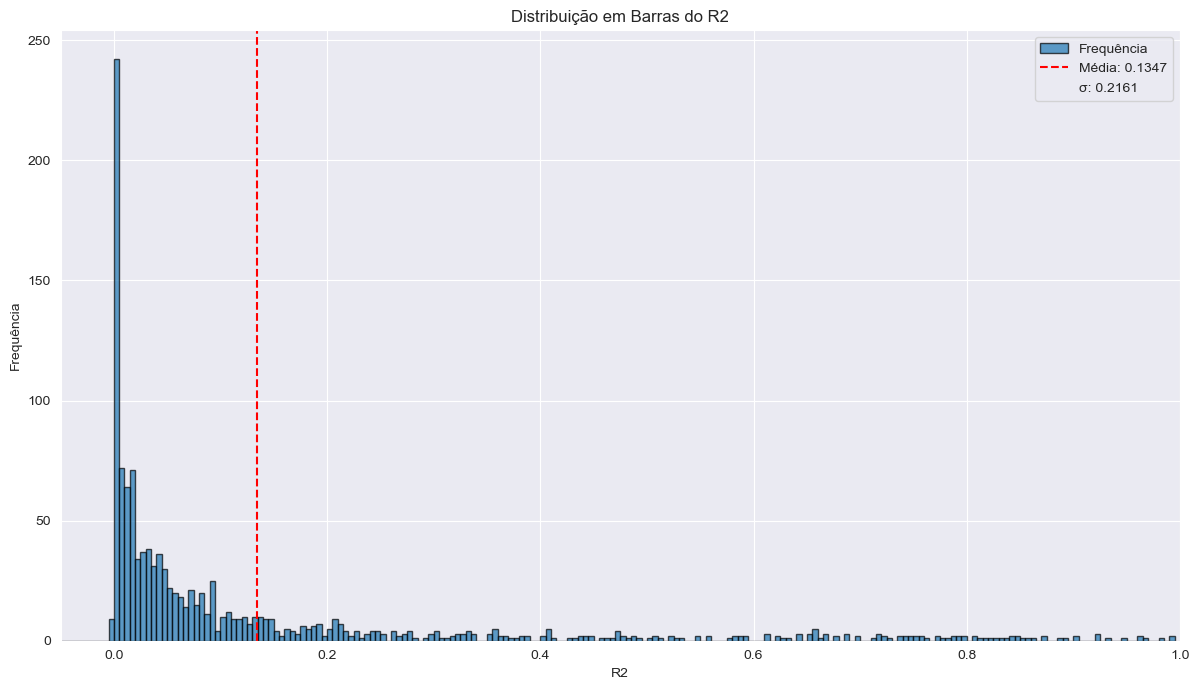

In [53]:
analise_r2 = df_resultados[['ticker_name', 'r2']]
# Parâmetros
dados = analise_r2['r2']

media = dados.mean()
desvio = dados.std()

min = -0.05
max = 1
bins = np.arange(min, max, 0.005)

# Plot
plt.figure(figsize=(12, 7))
plt.hist(dados, bins=bins, edgecolor='black', alpha=0.7, label='Frequência')

# Linhas de referência
plt.axvline(media, color='red', linestyle='--', label=f'Média: {media:.4f}')
plt.axvline(media, color='black', linestyle='none', linewidth=0, label=f'σ: {desvio:.4f}')

# Título e legenda
plt.title('Distribuição em Barras do R2')
plt.xlabel('R2')
plt.ylabel('Frequência')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.xlim(min,max)
plt.show()

In [34]:
analise_r2

,ticker_name,r2
0,A,0.001915
1,AAP,0.333119
2,AAPL,0.004954
3,AAT,0.091680
4,ABBV,0.471511
...,...,...
1209,ZBH,0.000006
1210,ZEUS,0.000415
1211,ZION,0.139944
1212,ZTR,0.384637


In [51]:
dados = analise_r2['r2']  # Agora analisando o R²

# Define as faixas de significância
limiares = np.arange(0, 1.01, 0.05)
tabela_resultado = []

for i, limite in enumerate(limiares):
    if i == 0:
        filtro = dados <= limite
    else:
        filtro = (dados > limiares[i - 1]) & (dados <= limite)

    subset = dados[filtro]
    stats = subset.describe()

    tabela_resultado.append({
        'Faixa': f'{f"{int(limiares[i - 1]*100)}%" if i > 0 else "Min"} <= {int(limite*100)}%',
        'Contagem': len(subset),
        'Média': round(stats['mean'],4) if not subset.empty else np.nan,
        'Mediana': round(stats['50%'],4) if not subset.empty else np.nan,
        'Desvio Padrão': round(stats['std'],4) if not subset.empty else np.nan,
        'Mínimo': round(stats['min'],4) if not subset.empty else np.nan,
        'Máximo': round(stats['max'],4) if not subset.empty else np.nan
    })

df_resultado = pd.DataFrame(tabela_resultado)

In [52]:
df_resultado

,Faixa,Contagem,Média,Mediana,Desvio Padrão,Mínimo,Máximo
0,Min <= 0%,20,-0.0000,0.0000,0.0000,-0.0000,0.0000
1,0% <= 5%,644,0.0156,0.0116,0.0150,0.0000,0.0494
2,5% <= 10%,170,0.0728,0.0732,0.0140,0.0504,0.0984
3,10% <= 15%,95,0.1244,0.1237,0.0145,0.1003,0.1487
4,15% <= 20%,44,0.1765,0.1767,0.0141,0.1510,0.1993
5,20% <= 25%,43,0.2209,0.2152,0.0155,0.2010,0.2485
6,25% <= 30%,21,0.2732,0.2744,0.0142,0.2537,0.2984
7,30% <= 35%,21,0.3222,0.3249,0.0125,0.3013,0.3386
8,35% <= 40%,18,0.3665,0.3637,0.0124,0.3517,0.3875
9,40% <= 45%,16,0.4226,0.4195,0.0170,0.4011,0.4476


In [53]:
df_resultados.describe().T

,count,mean,std,min,25%,50%,75%,max
alfa,1186.0,0.089093,3.565838,-1.190638e+01,-1.044727e-01,1.445387e-03,0.083034,119.868318
beta_dividendo,1214.0,-1.176453,13.999989,-4.653753e+02,-1.204533e+00,-8.635708e-01,-0.348307,50.818257
erro_alfa,1186.0,0.440787,2.325390,3.713175e-03,5.345231e-02,1.683169e-01,0.431453,74.583000
erro_beta,1214.0,1.713995,10.518330,1.956412e-03,3.067808e-01,6.290521e-01,1.253739,286.589317
significancia_alfa,1186.0,0.502794,0.299183,5.498139e-18,2.341147e-01,5.167112e-01,0.768043,0.999760
significancia_beta,1214.0,0.269936,0.311463,2.081590e-130,2.597219e-03,1.326739e-01,0.471776,0.999677
r2,1214.0,0.134695,0.216073,-2.220446e-16,8.260985e-03,4.119079e-02,0.139640,0.999838
r2_ajustado,1214.0,0.117691,0.220246,-2.609579e-02,-7.265162e-03,2.123992e-02,0.122210,0.999834
f_stat,1186.0,269.269910,7529.783271,1.654817e-07,5.184789e-01,2.338006e+00,10.004674,258463.054023
p_f_stat,1186.0,0.270651,0.311464,2.081590e-130,2.681358e-03,1.329016e-01,0.475390,0.999677


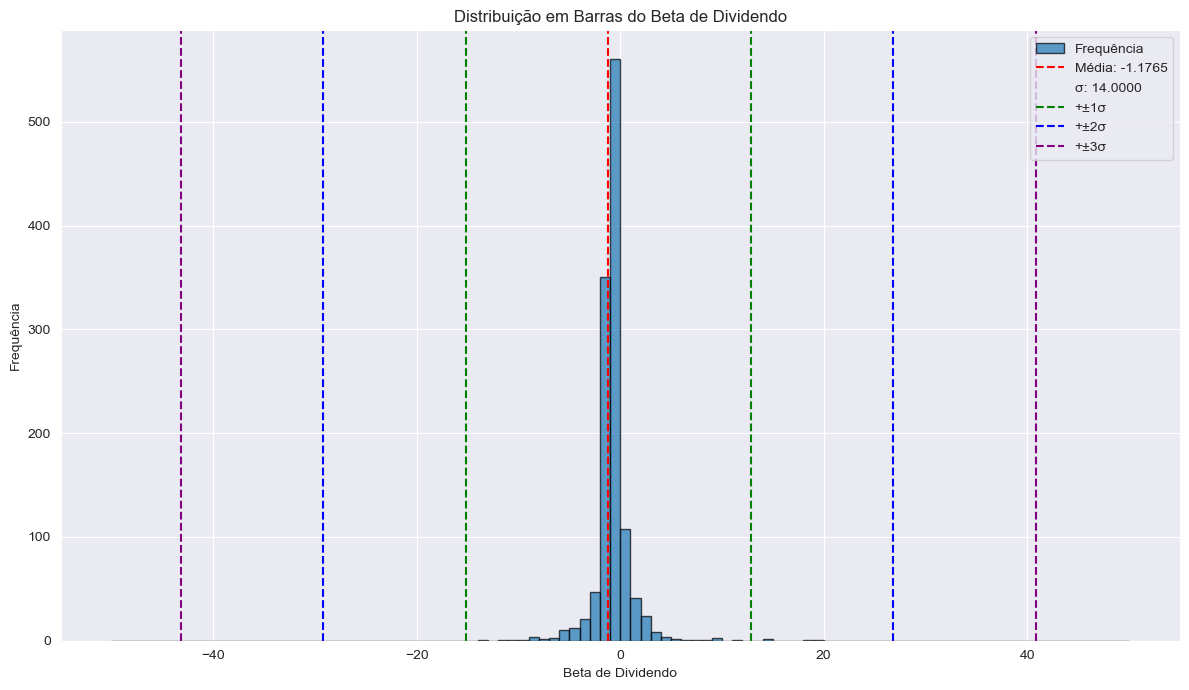

In [16]:
# Parâmetros
dados = df_resultados['beta_dividendo']
bins = np.arange(-50, 51, 1)
media = dados.mean()
desvio = dados.std()

# Plot
plt.figure(figsize=(12, 7))
plt.hist(dados, bins=bins, edgecolor='black', alpha=0.7, label='Frequência')

# Linhas de referência
plt.axvline(media, color='red', linestyle='--', label=f'Média: {media:.4f}')
plt.axvline(media, color='black', linestyle='none', linewidth=0, label=f'σ: {desvio:.4f}')
for i, color, label in zip([1, 2, 3], ['green', 'blue', 'purple'], [r'±1σ', r'±2σ', r'±3σ']):
    plt.axvline(media + i * desvio, color=color, linestyle='--', label=f'+{label}')
    plt.axvline(media - i * desvio, color=color, linestyle='--')

# Título e legenda
plt.title('Distribuição em Barras do Beta de Dividendo')
plt.xlabel('Beta de Dividendo')
plt.ylabel('Frequência')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


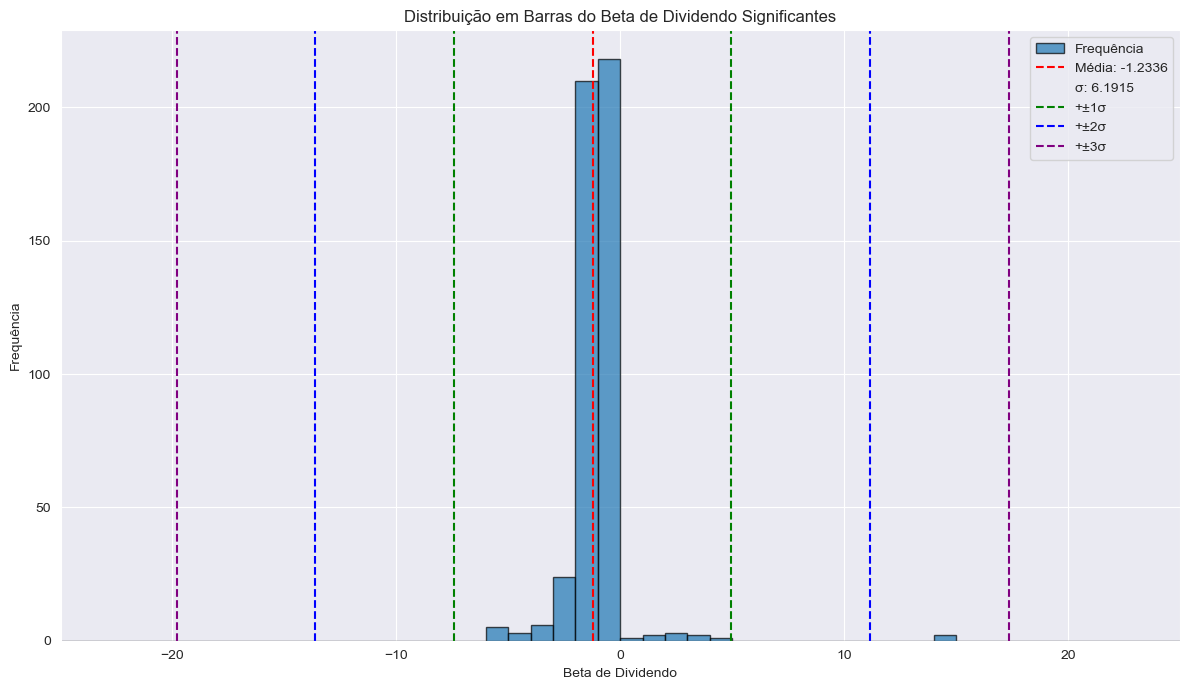

In [22]:
# Criar o gráfico de densidade do Beta de Dividendo
df_resultados_significantes = df_resultados.loc[df_resultados["significancia_beta"] < 0.05]
dados = df_resultados_significantes["beta_dividendo"]
bins = np.arange(-50, 51, 1)
media = dados.mean()
desvio = dados.std()

# Plot
plt.figure(figsize=(12, 7))
plt.hist(dados, bins=bins, edgecolor='black', alpha=0.7, label='Frequência')

# Linhas de referência
plt.axvline(media, color='red', linestyle='--', label=f'Média: {media:.4f}')
plt.axvline(media, color='black', linestyle='none', linewidth=0, label=f'σ: {desvio:.4f}')
for i, color, label in zip([1, 2, 3], ['green', 'blue', 'purple'], [r'±1σ', r'±2σ', r'±3σ']):
    plt.axvline(media + i * desvio, color=color, linestyle='--', label=f'+{label}')
    plt.axvline(media - i * desvio, color=color, linestyle='--')

# Título e legenda
plt.title('Distribuição em Barras do Beta de Dividendo Significantes')
plt.xlabel('Beta de Dividendo')
plt.ylabel('Frequência')
plt.xlim(-25,25)
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Recalcular as estatísticas para incluir média e desvio-padrão
df_resultados["r2_bin"] = (df_resultados["r2"] // 0.03) * 0.03

# Agrupar por faixas de R² e calcular os valores
grouped = df_resultados.groupby("r2_bin")["beta_dividendo"].agg(["min", "max", "mean", "std"])

# Definir limites de 3 desvios-padrão para cada lado
grouped["lower_bound"] = grouped["mean"] - 3 * grouped["std"]
grouped["upper_bound"] = grouped["mean"] + 3 * grouped["std"]

# Criar o gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Plotar as barras flutuantes (intervalo total de beta)
for i, (r2_bin, row) in enumerate(grouped.iterrows()):
    ax.plot([r2_bin, r2_bin], [row["min"], row["max"]], color="b", linewidth=4, alpha=0.5, label="Máx/Mín" if i == 0 else "")

# Plotar os intervalos de 3 desvios-padrão ao redor da média
for i, (r2_bin, row) in enumerate(grouped.iterrows()):
    ax.plot([r2_bin, r2_bin], [row["lower_bound"], row["upper_bound"]], color="orange", linewidth=4, alpha=0.9, label="Média ± 3σ" if i == 0 else "")

# Plotar a média de beta como pontos
ax.scatter(grouped.index, grouped["mean"], color="black", marker="o", s=50, label="Média")

# Adicionar a linha horizontal em -1
ax.axhline(y=-1, color="red", linestyle="--", linewidth=2, label="Linha em -1")

# Configurações do gráfico
ax.set_xlabel("Faixas de R²", fontsize=12)
ax.set_ylabel("Coeficiente Beta", fontsize=12)
ax.set_title("Distribuição do Beta por Faixa de R² (com Intervalo de Confiança)", fontsize=14)
ax.grid(True, linestyle="--", alpha=0.6)
ax.set_xticks(np.arange(0, 1.05, 0.05))
ax.set_xlim(-0.01, 1.01)
ax.set_ylim(-20, 20)
ax.legend()

# Mostrar gráfico
plt.show()

## Analise Beta

In [6]:
df_resultados

,ticker_name,alfa,beta_dividendo,erro_alfa,erro_beta,significancia_alfa,significancia_beta,r2,r2_ajustado,f_stat,...,max_cooks_distance,indice_outlier,possui_outlier_influente,residuo_p2_5,residuo_p25,residuo_p50,residuo_p75,residuo_p97_5,quantidade_residuos_extremos,resumo
0,A,0.135091,-0.502249,0.307535,1.769489,0.662717,7.779289e-01,0.001915,-0.021849,0.080564,...,0.181885,35,1,-0.942083,-0.307479,-0.041486,0.387687,1.134251,3,OLS Regression Res...
1,AAP,-0.038470,-1.288309,0.164697,0.281268,0.816448,4.106578e-05,0.333119,0.317240,20.979717,...,0.804014,33,1,-1.885948,-0.448037,0.045772,0.509466,1.717349,4,OLS Regression Res...
2,AAPL,-0.322935,1.371715,0.567732,2.964625,0.572441,6.459166e-01,0.004954,-0.018187,0.214086,...,0.310649,35,1,-1.382178,-0.414902,0.016044,0.276758,1.883380,4,OLS Regression Res...
3,AAT,0.218182,-1.759322,0.238175,0.844488,0.364746,4.320411e-02,0.091680,0.070556,4.340136,...,0.267781,24,1,-0.298560,-0.118258,0.024428,0.121650,0.273225,4,OLS Regression Res...
4,ABBV,0.542060,-1.523138,0.268981,0.245911,0.050158,1.909731e-07,0.471511,0.459220,38.364004,...,0.147671,35,1,-1.614107,-0.352342,-0.012300,0.398019,0.984153,4,OLS Regression Res...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1209,ZBH,-0.128568,0.157339,2.292630,9.900930,0.955545,9.873963e-01,0.000006,-0.023803,0.000253,...,0.380596,7,1,-1.310223,-0.256152,0.077342,0.235876,1.184804,4,OLS Regression Res...
1210,ZEUS,-0.034739,0.116477,0.061416,0.871849,0.574582,8.943440e-01,0.000415,-0.022831,0.017848,...,0.405038,29,1,-0.317105,-0.157591,-0.027590,0.102411,0.340916,4,OLS Regression Res...
1211,ZION,0.134733,-1.230960,0.137601,0.465367,0.332982,1.135682e-02,0.139944,0.119943,6.996763,...,0.115300,37,1,-0.772733,-0.247780,-0.055493,0.333743,0.895962,4,OLS Regression Res...
1212,ZTR,-0.004283,-0.928686,0.010666,0.101098,0.688670,6.380525e-16,0.384637,0.380079,84.382865,...,0.695571,37,1,-0.112948,-0.023065,0.004150,0.030717,0.104949,8,OLS Regression Res...


In [7]:
df_resultados['beta_dividendo']

0      -0.502249
1      -1.288309
2       1.371715
3      -1.759322
4      -1.523138
          ...   
1209    0.157339
1210    0.116477
1211   -1.230960
1212   -0.928686
1213   -1.499763
Name: beta_dividendo, Length: 1214, dtype: float64

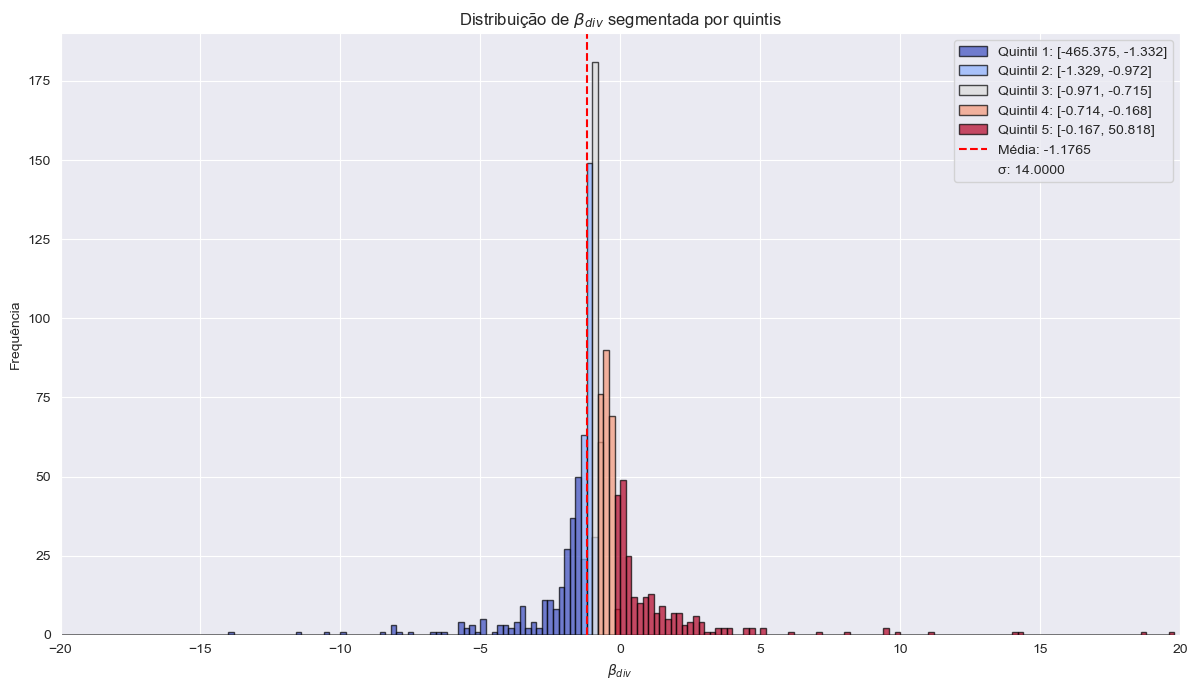

In [23]:
dados = df_resultados['beta_dividendo']

# Define os quintis (com labels numéricos de 0 a 4)
# Número de grupos (pode trocar aqui por 4, 5, 10, etc.)
k = 5

# Segmenta os dados com qcut
quintis = pd.qcut(dados, q=k, labels=False, duplicates='drop')

# Cria paleta de cores em gradiente (colormap 'coolwarm' ou qualquer outro)
cmap = matplotlib.colormaps['coolwarm']
cores = [cmap(i / (k - 1)) for i in range(k)]

# DataFrame com valores e quintis
df_quintil = pd.DataFrame({'valor': dados, 'quintil': quintis})

# Parâmetros do gráfico
min_x = -20
max_x = 20
bins = np.arange(min_x, max_x, 0.2)

# Criação do gráfico
plt.figure(figsize=(12, 7))
for q in range(k):
    subset = df_quintil[df_quintil['quintil'] == q]['valor']
    q_min = subset.min()
    q_max = subset.max()
    label = f'Quintil {q+1}: [{q_min:.3f}, {q_max:.3f}]'
    plt.hist(subset, bins=bins, alpha=0.7, label=label, color=cores[q], edgecolor='black')

# Linhas de média e desvio
media = dados.mean()
desvio = dados.std()
plt.axvline(media, color='red', linestyle='--', label=f'Média: {media:.4f}')
plt.axvline(media, color='black', linestyle='none', linewidth=0, label=f'σ: {desvio:.4f}')

# Título e eixos com LaTeX
plt.title(r'Distribuição de $\beta_{div}$ segmentada por quintis')
plt.xlabel(r'$\beta_{div}$')
plt.ylabel('Frequência')

# Estética final
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.xlim(min_x, max_x)
plt.show()


In [26]:
p5 = dados.quantile(0.05)
p95 = dados.quantile(0.95)

df_limpa = df_resultados[(df_resultados['beta_dividendo'] >= p5) & (df_resultados['beta_dividendo'] <= p95)]


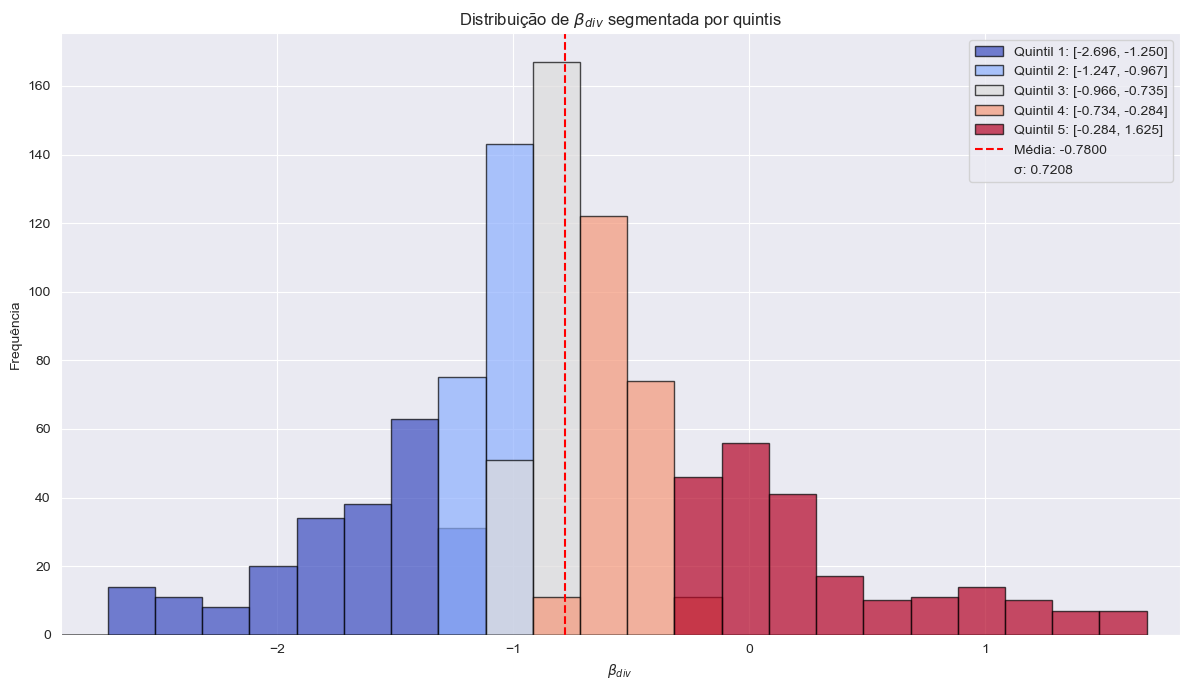

In [29]:
dados = df_limpa['beta_dividendo']

# Define os quintis (com labels numéricos de 0 a 4)
# Número de grupos (pode trocar aqui por 4, 5, 10, etc.)
k = 5

# Segmenta os dados com qcut
quintis = pd.qcut(dados, q=k, labels=False, duplicates='drop')

# Cria paleta de cores em gradiente (colormap 'coolwarm' ou qualquer outro)
cmap = matplotlib.colormaps['coolwarm']
cores = [cmap(i / (k - 1)) for i in range(k)]

# DataFrame com valores e quintis
df_quintil = pd.DataFrame({'valor': dados, 'quintil': quintis})

# Parâmetros do gráfico
min_x = p5 - 0.20
max_x = p95 + 0.20
bins = np.arange(min_x, max_x, 0.2)

# Criação do gráfico
plt.figure(figsize=(12, 7))
for q in range(k):
    subset = df_quintil[df_quintil['quintil'] == q]['valor']
    q_min = subset.min()
    q_max = subset.max()
    label = f'Quintil {q+1}: [{q_min:.3f}, {q_max:.3f}]'
    plt.hist(subset, bins=bins, alpha=0.7, label=label, color=cores[q], edgecolor='black')

# Linhas de média e desvio
media = dados.mean()
desvio = dados.std()
plt.axvline(media, color='red', linestyle='--', label=f'Média: {media:.4f}')
plt.axvline(media, color='black', linestyle='none', linewidth=0, label=f'σ: {desvio:.4f}')

# Título e eixos com LaTeX
plt.title(r'Distribuição de $\beta_{div}$ segmentada por quintis')
plt.xlabel(r'$\beta_{div}$')
plt.ylabel('Frequência')

# Estética final
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.xlim(min_x, max_x)
plt.show()


## O que explica o β_div?

In [30]:
query_final = """
WITH dividendos_filtrados AS (
    SELECT
        ca.ticker_name,
        t.sector_key,
        t.full_exchange_name,
        ca.Date,
        ca.Dividends,
        ca.fechamento_ontem
    FROM cotacoes_ativos ca
    LEFT JOIN tickers t ON t.ticker_name = ca.ticker_name
    WHERE ca.Dividends != 0
),
dias_entre_dividendos AS (
    SELECT
        ticker_name,
        Date,
        Dividends,
        julianday(Date) - julianday(
            LAG(Date) OVER (PARTITION BY ticker_name ORDER BY Date)
        ) AS dias_entre
    FROM dividendos_filtrados
),
periodo_medio AS (
    SELECT
        ticker_name,
        AVG(dias_entre) AS avg_dias_entre_div
    FROM dias_entre_dividendos
    WHERE dias_entre IS NOT NULL
    GROUP BY ticker_name
),
crescimento_div AS (
    SELECT
        df.*,
        LAG(Dividends) OVER (PARTITION BY ticker_name ORDER BY Date) AS prev_div
    FROM dividendos_filtrados df
),
crescimento_agrupado AS (
    SELECT
        ticker_name,
        sector_key,
        full_exchange_name,
        AVG(Dividends / fechamento_ontem) AS proxy_div_yield,
        AVG(
            CASE
                WHEN prev_div IS NOT NULL AND prev_div > 0
                THEN (Dividends - prev_div) / prev_div
                ELSE NULL
            END
        ) AS avg_div_growth
    FROM crescimento_div
    GROUP BY ticker_name, sector_key, full_exchange_name
)
SELECT
    bdb.beta_dividendo,
    c.*,
    p.avg_dias_entre_div / 30.44 AS 'avg_tempo_entre_divs_meses'
FROM crescimento_agrupado c
LEFT JOIN periodo_medio p USING (ticker_name)
LEFT JOIN beta_dividendo_bruto bdb
    on bdb.ticker_name = c.ticker_name;
"""

df_explicando_beta = pd.read_sql(query_final, conn)

In [59]:
df_filtrada = df_explicando_beta[
    df_explicando_beta['ticker_name'].isin(df_limpa['ticker_name'])
]

In [65]:
# df_filtrada.to_csv("bot, explica essa para mim.csv", index=False)

In [63]:
X_base = df_filtrada[[
    "proxy_div_yield",
    "avg_div_growth",
    "avg_tempo_entre_divs_meses"
]]

# 2. Cria as dummies
d_sector  = pd.get_dummies(df_filtrada["sector_key"],
                           prefix="sector", drop_first=True,dtype=int)  # baseline implícito
d_exchange = pd.get_dummies(df_filtrada["full_exchange_name"],
                            prefix="exch", drop_first=True,dtype=int)

# 3. Garante ordem: primeiro X_base, depois dummies
X = pd.concat([X_base, d_sector, d_exchange], axis=1)

# 4. Adiciona o intercepto (α)
X = sm.add_constant(X, has_constant="add")

# 5. Variável dependente
y = df_filtrada["beta_dividendo"]

# 6. Ajusta o modelo OLS com erros robustos (HC3)
model = sm.OLS(y, X).fit(cov_type="HC3")

In [64]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         beta_dividendo   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.518
Date:                ter, 22 abr 2025   Prob (F-statistic):           0.000338
Time:                        10:50:04   Log-Likelihood:                -1172.3
No. Observations:                1092   AIC:                             2385.
Df Residuals:                    1072   BIC:                             2484.
Df Model:                          19                                         
Covariance Type:                  HC3                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

## OUTLIERS

### Obtendo Outliers

In [ ]:
query_betas = """
SELECT bdb.beta_dividendo
FROM beta_dividendo_bruto bdb
"""
df_betas = pd.read_sql(query_betas, conn)

Q1 = df_betas['beta_dividendo'].quantile(0.25)
Q3 = df_betas['beta_dividendo'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR


In [ ]:
query_outliers = f"""
SELECT *
FROM beta_dividendo_bruto bdb
WHERE
    bdb.beta_dividendo < {limite_inferior}
    OR bdb.beta_dividendo > {limite_superior};
"""

df_outliers = pd.read_sql(query_outliers, conn)

### Outliers = Volume?

In [ ]:

conn.create_aggregate("stdev", 1, StdevFunc)
query_dados_com_beta = """
SELECT
    bdb.*,
    t.beta as 'Beta CAPM',
    t.market_cap,
    t.dividend_rate,
    t.dividend_yield,
    t.payout_ratio,
    t.price_to_book,
    t.price_to_earnings,
    t.free_cashflow,
    avg(p.Volume) as 'Volume Medio',
    stdev(p.Volume) as 'Desvio Volume'
FROM tickers t
INNER JOIN beta_dividendo_bruto bdb
    ON bdb.ticker_name = t.ticker_name
INNER JOIN prices p on bdb.ticker_name = p.ticker_name
group by t.ticker_name;
"""
df = pd.read_sql(query_dados_com_beta, conn)

df = df[(df["beta_dividendo"] > -10) & (df["beta_dividendo"] < 10)]
df['log_volume_medio'] = np.log10(df['Volume Medio'])

# 1. Garantir que as colunas necessárias existem
df['log_volume_medio'] = np.log10(df['Volume Medio'] + 1)
df['faixa_volume'] = pd.cut(df['log_volume_medio'], bins=6)

# 2. Função customizada para desenhar no FacetGrid
def plot_beta_com_linhas(data, color=None, **kwargs):
    ax = plt.gca()

    # Histograma com KDE
    sns.histplot(data['beta_dividendo'], bins=30, kde=True, ax=ax, color=color)

    # Linhas verticais
    media = data['beta_dividendo'].mean()
    std = data['beta_dividendo'].std()

    ax.axvline(-1, color='white', linestyle='--', label='Linha -1')
    ax.axvline(media, color='yellow', linestyle='-', label='Média')

    # Desvios padrão
    for i in range(1, 4):
        ax.axvline(media + i*std, color='red', linestyle='--', alpha=0.7)
        ax.axvline(media - i*std, color='red', linestyle='--', alpha=0.7)

# 3. Criar FacetGrid e aplicar a função
g = sns.FacetGrid(df, col='faixa_volume', col_wrap=3, height=4, sharey=True)
g.map_dataframe(plot_beta_com_linhas)

# 4. Ajustar layout
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Distribuição de beta_dividendo com média, desvios e linha em -1")
plt.show()


In [ ]:
df.groupby('faixa_volume', observed=True)['beta_dividendo'].agg(['mean', 'std', 'count'])

In [ ]:

df['log_desvio_volume'] = np.log10(df['Desvio Volume'])
df['faixa_log_desvio_volume'] = pd.cut(df['log_desvio_volume'], bins=6)

g = sns.FacetGrid(df, col='faixa_log_desvio_volume', col_wrap=3, height=4, sharey=True)
g.map_dataframe(plot_beta_com_linhas)

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Distribuição de beta_dividendo por log(desvio do volume médio)")
plt.show()

In [ ]:
df.groupby('faixa_log_desvio_volume', observed=True)['beta_dividendo'].agg(['count', 'mean', 'std'])

In [ ]:
tickers_outliers = tuple(df_outliers['ticker_name'].unique())
df['é_outlier'] = df['ticker_name'].isin(tickers_outliers)

In [ ]:
# Define o número de intervalos desejados
num_bins = 20
min_val = df['log_volume_medio'].min()
max_val = df['log_volume_medio'].max()

# Cria os intervalos (bins)
bins = np.linspace(min_val, max_val, num_bins + 1)

# Agrupa os dados em intervalos
df['bin'] = pd.cut(df['log_volume_medio'], bins=bins)

# Agrupa os dados por intervalo e pelo flag de outlier, contando os registros
group_counts = df.groupby(['bin', 'é_outlier'], observed=True).size().unstack(fill_value=0)

# Calcula a coluna Total (soma de outliers e não outliers)
group_counts['Total'] = group_counts[False] + group_counts[True]

# Reordena as colunas para que Total venha antes de Não Outlier
group_counts = group_counts[['Total', False, True]]

# Define posições no eixo X para cada intervalo e a largura de cada barra
x = np.arange(len(group_counts.index))
width = 0.25

plt.figure(figsize=(12, 6))

# Plota a barra Total (antes das demais)
plt.bar(x - width, group_counts['Total'], width, label='Total', color='gray')
# Plota a barra Não Outlier (False)
plt.bar(x, group_counts[False], width, label='Não Outlier', color='blue')
# Plota a barra Outlier (True)
plt.bar(x + width, group_counts[True], width, label='Outlier', color='red')

# Formata os labels do eixo X com os intervalos
interval_labels = [f'{interval.left:.2f} a {interval.right:.2f}' for interval in group_counts.index]
plt.xticks(x, interval_labels, rotation=45)

# Eixos e título
plt.xlabel('Intervalos do Log do Volume Médio')
plt.ylabel('Contagem de Valores')
plt.title('Contagem por Intervalos do Log(Volume Médio)\n(Total, Não Outliers e Outliers)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
len(df)

### Hipotese Setores = Outliers

In [ ]:
tickers_outliers = tuple(df_outliers['ticker_name'].unique())

query_setores_outliers = """
SELECT t.sector, COUNT(t.sector)
FROM tickers t
WHERE t.ticker_name IN ({seq})
GROUP BY t.sector
""".format(seq=','.join(['?'] * len(tickers_outliers)))

cursor = conn.cursor()
cursor.execute(query_setores_outliers, tickers_outliers)
resultados = cursor.fetchall()
cursor.close()

setores_outliers = pd.DataFrame(resultados)

In [ ]:
query_setores_totais = """
SELECT t.sector, COUNT(t.sector)
FROM tickers t
GROUP BY t.sector
"""
setores_totais = pd.read_sql(query_setores_totais, conn)


In [ ]:
setores_outliers.columns = ['Setores', "Contagem Outlier"]
setores_totais.columns = ['Setores', "Contagem"]

In [ ]:
df_setores = setores_totais.merge(setores_outliers, on='Setores', how='left')

In [ ]:
df_setores['Contagem Outlier'] = df_setores['Contagem Outlier'].fillna(0).astype(int)
df_setores['% Outlier'] = (df_setores['Contagem Outlier'] / df_setores['Contagem']) * 100

In [ ]:
df_setores

### Testes Outliers Individuais

- Valida, mas como fazer em larga escala?

In [ ]:
ticker_name = "AYI"

# Query original que você já tem
query_cotacoes_por_ativo = """
with cotacoes AS (
    SELECT ticker_name,
         Date,
         Open,
         Close,
         Dividends,
         LAG(Close, 1) OVER (PARTITION BY ticker_name ORDER BY Date) AS fechamento_ontem
    FROM prices
)
SELECT *
FROM cotacoes as c
where
    fechamento_ontem IS NOT NULL AND
    ticker_name == ?;
"""

# Lendo dados
df = pd.read_sql(query_cotacoes_por_ativo, conn, params=[ticker_name])

# Filtrando apenas eventos com dividendos
df = df[df["Dividends"] != 0].copy()

df['Date'] = pd.to_datetime(df['Date'], utc=True)
df['Date'] = df['Date'].dt.tz_convert(None)
df['Date'] = pd.to_datetime(df['Date']).dt.normalize()

df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None)

# Lista de datas a remover (sem timezone)
# Exemplo     '2024-11-20',
datas_remover = [

]

# Converte para datetime sem timezone
datas_remover = pd.to_datetime(datas_remover)

# Filtra
df = df[~df['Date'].isin(datas_remover)]

# Calculando variação real
df["ajuste"] = df["Open"] - df["fechamento_ontem"]

# Rodando regressão
X = sm.add_constant(df[["Dividends"]])
y = df["ajuste"]

modelo = sm.OLS(y, X).fit()

# Mostra os parâmetros
print("\n📊 Regressão para:", ticker_name)
print("Beta:", modelo.params["Dividends"])
print("Intercepto:", modelo.params["const"])
print("R²:", modelo.rsquared)
print("P-valor:", modelo.pvalues["Dividends"])

In [ ]:
# Inclui resíduos para investigar pontos anômalos
df["residuo"] = modelo.resid
df["ajuste_previsto"] = modelo.predict(X)

# Mostra os eventos ordenados pelos resíduos mais extremos
print("\n🔎 Top eventos que mais puxaram a regressão (maior desvio):")
df.sort_values("residuo", key=abs, ascending=False).head(20)[
    ["Date", "Dividends", "fechamento_ontem", "Open", "ajuste", "ajuste_previsto", "residuo"]
]

### Hipotese Yield

Trago pela AAPL pelo baixa distribuição de dividendo perto dos preços, 0,23 com o preço sendo 165, potencial

In [ ]:
query_yield = """
WITH cotacoes AS (
    SELECT
        ticker_name,
        Date,
        Open,
        Close,
        Dividends,
        LAG(Close, 1) OVER (PARTITION BY ticker_name ORDER BY Date) AS fechamento_ontem
    FROM prices
)
SELECT
    ticker_name,
    AVG(Dividends / fechamento_ontem) AS dividend_yield
FROM cotacoes
WHERE
    fechamento_ontem IS NOT NULL
    AND Dividends != 0
GROUP BY ticker_name;
"""

df_yield_medio = pd.read_sql(query_yield, conn)

In [ ]:
# Lista dos tickers outliers
tickers_outliers = set(df_outliers['ticker_name'])

# Criando coluna para marcar se é outlier ou não
df_yield_medio['é_outlier'] = df_yield_medio['ticker_name'].isin(tickers_outliers)


In [ ]:
df_outliers_yield = df_yield_medio[df_yield_medio['é_outlier']]
df_nao_outliers_yield = df_yield_medio[~df_yield_medio['é_outlier']]


In [ ]:
df_plot = pd.concat([
    df_outliers_yield.assign(grupo="Outliers"),
    df_nao_outliers_yield.assign(grupo="Não Outliers")
])

plt.figure(figsize=(10, 6))

# Plot individual para cada grupo, com label explícito
sns.kdeplot(
    data=df_plot[df_plot["grupo"] == "Outliers"],
    x="dividend_yield",
    fill=True,
    alpha=0.5,
    linewidth=2,
    label="Outliers"
)

sns.kdeplot(
    data=df_plot[df_plot["grupo"] == "Não Outliers"],
    x="dividend_yield",
    fill=True,
    alpha=0.5,
    linewidth=2,
    label="Não Outliers"
)

plt.title("Distribuição do Dividend Yield Médio: Outliers vs Não Outliers", fontsize=14)
plt.xlabel("Dividend Yield Médio", fontsize=12)
plt.ylabel("Densidade", fontsize=12)
plt.legend(title="Grupo", title_fontsize=11, fontsize=10)
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


### Hipotese Ruido > Dividendo

Potencial

In [ ]:
outlier_ticker_teste = df_outliers['ticker_name'][9]

In [ ]:
outlier_ticker_teste = "ABR"

In [ ]:
query_cotacoes = """with cotacoes AS (
    SELECT ticker_name,
         Date,
         Open,
         Close,
         Dividends,
         LAG(Close, 1) OVER (PARTITION BY ticker_name ORDER BY Date) AS fechamento_ontem
    FROM prices
)
SELECT *, abs(fechamento_ontem - Open) as 'Diferenca Absoluta'
FROM cotacoes as c
where
    fechamento_ontem IS NOT NULL AND
    ticker_name = ?;
"""

df_cotacoes = pd.read_sql(query_cotacoes, conn, params=(outlier_ticker_teste,))

In [ ]:
df_cotacoes.head()

In [ ]:
dividends_filtrados = df_cotacoes['Dividends'][df_cotacoes['Dividends'] > 0]

plt.figure(figsize=(10, 6))

# Densidades
sns.kdeplot(df_cotacoes['Diferenca Absoluta'], label='Diferença Absoluta', fill=True, alpha=0.5)
sns.kdeplot(dividends_filtrados, label='Dividends', fill=True, alpha=0.5)

# Estatísticas
media_abs = df_cotacoes['Diferenca Absoluta'].mean()
mediana_abs = df_cotacoes['Diferenca Absoluta'].median()
std_abs = df_cotacoes['Diferenca Absoluta'].std()

media_div = dividends_filtrados.mean()
mediana_div = dividends_filtrados.median()
std_div = dividends_filtrados.std()

# Linhas verticais - Diferença Absoluta
plt.axvline(mediana_abs, color='blue', linestyle='--', linewidth=1.2, label='Mediana Diferença')
plt.axvline(media_abs, color='blue', linestyle='-', linewidth=1.2, label='Média Diferença')
plt.axvline(media_abs + std_abs, color='blue', linestyle=':', linewidth=1.2, label='±1 DP Diferença')
plt.axvline(media_abs - std_abs, color='blue', linestyle=':', linewidth=1.2)

# Linhas verticais - Dividends
plt.axvline(mediana_div, color='orange', linestyle='--', linewidth=1.2, label='Mediana Dividends')
plt.axvline(media_div, color='orange', linestyle='-', linewidth=1.2, label='Média Dividends')
plt.axvline(media_div + std_div, color='orange', linestyle=':', linewidth=1.2, label='±1 DP Dividends')
plt.axvline(media_div - std_div, color='orange', linestyle=':', linewidth=1.2)

# Gráfico
plt.title('Distribuição: Diferença Absoluta vs. Dividends com Média, Mediana e Desvio Padrão')
plt.xlabel('Valor')
plt.ylabel('Densidade')
plt.legend()
plt.xlim(-0.01, 1)
plt.tight_layout()
plt.show()


In [ ]:
# df_outliers
df_todos_tickers = pd.read_sql("SELECT * FROM tickers_ativos", conn)
df_todos_tickers['e_outlier'] = df_todos_tickers['ticker_name'].isin(df_outliers['ticker_name'])

In [ ]:
def verificar_ruidos_e_dividendos(ticker):
    df_cotacoes = pd.read_sql(query_cotacoes, conn, params=(ticker,))

    # Converter a coluna Date para datetime
    df_cotacoes['Date'] = pd.to_datetime(df_cotacoes['Date'].str.split(' ').str[0])

    # Ordenar por data para garantir sequência correta
    df_cotacoes.sort_values('Date', inplace=True)

    # Descrição geral
    descricao_diff = df_cotacoes['Diferenca Absoluta'].describe()
    df_filtrada = df_cotacoes[df_cotacoes['Dividends'] > 0]
    descricao_div = df_filtrada['Dividends'].describe()

    # Lista para armazenar os percentis temporais
    percentis_temporais = []

    for _, row in df_filtrada.iterrows():
        data_dividendo = row['Date']
        valor_dividendo = row['Dividends']

        # Janela de 30 dias anteriores
        janela = df_cotacoes[
            (df_cotacoes['Date'] < data_dividendo) &
            (df_cotacoes['Date'] >= data_dividendo - pd.Timedelta(days=30)) &
            (df_cotacoes['Dividends'] == 0)
        ]

        # Evita erros em casos com janela vazia
        if not janela.empty:
            percentil = percentileofscore(janela['Diferenca Absoluta'], valor_dividendo)
            percentis_temporais.append(percentil)

    # Estatísticas da análise temporal dos dividendos
    if percentis_temporais:
        media_percentil = sum(percentis_temporais) / len(percentis_temporais)
        desvio_percentil = pd.Series(percentis_temporais).std()
    else:
        media_percentil = None
        desvio_percentil = None

    estatisticas = {
        "ticker_row": ticker,
        "Count_Diff": descricao_diff['count'],
        "Media_Diff": descricao_diff['mean'],
        "Mediana_Diff": descricao_diff['50%'],
        "Desvio_Diff": descricao_diff['std'],
        "1Q_Diff": descricao_diff['25%'],
        "3Q_Diff": descricao_diff['75%'],
        "Count_Div": descricao_div.get('count', 0),
        "Media_Div": descricao_div.get('mean', 0),
        "Mediana_Div": descricao_div.get('50%', 0),
        "Desvio_Div": descricao_div.get('std', 0),
        "1Q_Div": descricao_div.get('25%', 0),
        "3Q_Div": descricao_div.get('75%', 0),
        "Media_Percentil_Div_em_Diff30d": media_percentil,
        "Desvio_Percentil_Div_em_Diff30d": desvio_percentil
    }

    return estatisticas


In [ ]:
df_estatisticas = df_todos_tickers['ticker_name'].apply(verificar_ruidos_e_dividendos).apply(pd.Series)

In [ ]:
df_estatisticas

In [ ]:
df_todos_tickers = df_todos_tickers.merge(df_estatisticas, left_on='ticker_name', right_on='ticker_row')

In [ ]:
df_todos_tickers.columns

In [ ]:
df_todos_tickers['diff_medias'] = df_todos_tickers['Media_Diff'] - df_todos_tickers['Media_Div']
df_todos_tickers['diff_medianas'] = df_todos_tickers['Mediana_Diff'] - df_todos_tickers['Mediana_Div']
df_todos_tickers['razao_medias'] = df_todos_tickers['Media_Diff'] / df_todos_tickers['Media_Div']

In [ ]:
grupo_outlier = df_todos_tickers[df_todos_tickers['e_outlier'] == True]['diff_medias']
grupo_normal = df_todos_tickers[df_todos_tickers['e_outlier'] == False]['diff_medias']
stat, p = ttest_ind(grupo_outlier, grupo_normal, equal_var=False)
print(f'Teste t - Diferença de Médias: stat={stat:.2f}, p-valor={p:.4f}')

In [ ]:
# Define a variável dependente (y) e independente (X)
X = df_todos_tickers[['diff_medias']]
X = sm.add_constant(X)  # adiciona o intercepto
y = df_todos_tickers['e_outlier'].astype(int)  # transforma True/False em 1/0

# Ajusta o modelo logit
modelo_logit = sm.Logit(y, X)
resultado = modelo_logit.fit()

# Exibe o resumo
print(resultado.summary())

In [ ]:
# Cria as cores para cada ponto
cores = df_todos_tickers['e_outlier'].map({True: 'red', False: 'blue'})

# Cria o gráfico de dispersão
plt.figure(figsize=(12, 6))
plt.scatter(df_todos_tickers['diff_medias'], df_todos_tickers['diff_medianas'], c=cores, alpha=0.7)

# Eixos e título
plt.xlabel('Diferença da Média de Dividendos para Ruidos')
plt.ylabel('Diferença da Mediana de Dividendos para Ruido')
plt.title('Dispersão: Diferença Média vs Mediana\nOutliers em Vermelho')

# Grid e layout
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Filtra os dados
df_outliers = df_todos_tickers[df_todos_tickers['e_outlier'] == True]
df_normais = df_todos_tickers[df_todos_tickers['e_outlier'] == False]

# Define as cores
cores_outliers = df_outliers['e_outlier'].map({True: 'red', False: 'blue'})
cores_normais = df_normais['e_outlier'].map({True: 'red', False: 'blue'})

# Gráfico 1 - Apenas Outliers
plt.figure(figsize=(12, 6))
plt.scatter(df_outliers['diff_medias'], df_outliers['diff_medianas'], c=cores_outliers, alpha=0.8)
plt.xlabel('Diferença da Média de Dividendos para Ruidos')
plt.ylabel('Diferença da Mediana de Dividendos para Ruido')
plt.title('Apenas Outliers (em Vermelho)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:

# Gráfico 2 - Apenas Valores Normais
plt.figure(figsize=(12, 6))
plt.scatter(df_normais['diff_medias'], df_normais['diff_medianas'], c=cores_normais, alpha=0.8)
plt.xlabel('Diferença da Média de Dividendos para Ruidos')
plt.ylabel('Diferença da Mediana de Dividendos para Ruido')
plt.title('Apenas Valores Não-Outliers (Azul)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Define o número de intervalos desejados
num_bins = 20
min_val = df_todos_tickers['diff_medias'].min()
max_val = df_todos_tickers['diff_medias'].max()

# Cria os intervalos (bins)
bins = np.linspace(min_val, max_val, num_bins + 1)

# Agrupa os dados em intervalos
df_todos_tickers['bin'] = pd.cut(df_todos_tickers['diff_medias'], bins=bins)

# Agrupa os dados por intervalo e pelo flag de outlier, contando os registros
group_counts = df_todos_tickers.groupby(['bin', 'e_outlier'], observed=True).size().unstack(fill_value=0)

# Calcula a coluna Total (soma de outliers e não outliers)
group_counts['Total'] = group_counts[False] + group_counts[True]

# Reordena as colunas para que Total venha antes de Não Outlier
group_counts = group_counts[['Total', False, True]]

# Define posições no eixo X para cada intervalo e a largura de cada barra
x = np.arange(len(group_counts.index))
width = 0.25

plt.figure(figsize=(12, 6))

# Plota a barra Total (antes das demais)
plt.bar(x - width, group_counts['Total'], width, label='Total', color='gray')
# Plota a barra Não Outlier (False)
plt.bar(x, group_counts[False], width, label='Não Outlier', color='blue')
# Plota a barra Outlier (True)
plt.bar(x + width, group_counts[True], width, label='Outlier', color='red')

# Formata os labels do eixo X com os intervalos
interval_labels = [f'{interval.left:.2f} a {interval.right:.2f}' for interval in group_counts.index]
plt.xticks(x, interval_labels, rotation=45)

# Eixos e título
plt.xlabel('Intervalos da Média de Dividendos')
plt.ylabel('Contagem de Valores')
plt.title('Contagem por Intervalos da Média de Dividendos\n(Total, Não Outliers e Outliers)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Mapeia cores com base em outliers
cores = df_todos_tickers['e_outlier'].map({True: 'red', False: 'blue'})

# Cria o gráfico de dispersão
plt.figure(figsize=(12, 6))
plt.scatter(
    df_todos_tickers['Media_Percentil_Div_em_Diff30d'],
    df_todos_tickers['Desvio_Percentil_Div_em_Diff30d'],
    c=cores,
    alpha=0.7
)

# Eixos e título
plt.xlabel('Média dos Percentis de Dividendos no Ruído (30d)')
plt.ylabel('Desvio dos Percentis de Dividendos no Ruído (30d)')
plt.title('Dispersão: Média vs Desvio dos Percentis Temporais\nOutliers em Vermelho')

# Grid e layout
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Define o número de intervalos desejados
num_bins = 10
min_val = 0
max_val = 100

# Cria os intervalos (bins)
bins = np.linspace(min_val, max_val, num_bins + 1)

# Agrupa os dados em intervalos
df_todos_tickers['bin'] = pd.cut(df_todos_tickers['Media_Percentil_Div_em_Diff30d'], bins=bins)

# Agrupa os dados por intervalo e pelo flag de outlier, contando os registros
group_counts = df_todos_tickers.groupby(['bin', 'e_outlier'], observed=True).size().unstack(fill_value=0)

# Calcula a coluna Total (soma de outliers e não outliers)
group_counts['Total'] = group_counts[False] + group_counts[True]

# Reordena as colunas para que Total venha antes de Não Outlier
group_counts = group_counts[['Total', False, True]]

# Define posições no eixo X para cada intervalo e a largura de cada barra
x = np.arange(len(group_counts.index))
width = 0.25

plt.figure(figsize=(14, 6))

# Plota as barras
plt.bar(x - width, group_counts['Total'], width, label='Total', color='gray')
plt.bar(x, group_counts[False], width, label='Não Outlier', color='blue')
plt.bar(x + width, group_counts[True], width, label='Outlier', color='red')

# Formata os labels do eixo X com os intervalos
interval_labels = [f'{interval.left:.1f} a {interval.right:.1f}' for interval in group_counts.index]
plt.xticks(x, interval_labels, rotation=45)

# Eixos e título
plt.xlabel('Intervalos da Média dos Percentis dos Dividendos (30d)')
plt.ylabel('Contagem de Ativos')
plt.title('Contagem por Intervalos da Média dos Percentis\nTotal, Não Outliers e Outliers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
num_bins = 10
min_val = 0
max_val = 100


# Cria os intervalos (bins)
bins = np.linspace(min_val, max_val, num_bins + 1)
df_todos_tickers['bin'] = pd.cut(df_todos_tickers['Media_Percentil_Div_em_Diff30d'], bins=bins)

# Agrupa os dados por intervalo e pelo flag de outlier, contando os registros
group_counts = df_todos_tickers.groupby(['bin', 'e_outlier'], observed=True).size().unstack(fill_value=0)

# Cria coluna Total e calcula os percentuais
group_counts['Total'] = group_counts[False] + group_counts[True]
group_counts['Não Outlier'] = group_counts[False]
group_counts['% Não Outlier'] = round((group_counts[False] / group_counts['Total']) * 100,4)
group_counts['Outlier'] = group_counts[True]
group_counts['% Outlier'] = round((group_counts[True] / group_counts['Total']) * 100,4)

# Reorganiza as colunas
df_percentuais = group_counts[['Não Outlier', '% Não Outlier', 'Outlier', '% Outlier', 'Total']].reset_index()
df_percentuais.columns.name = None

# Mostra o resultado
df_percentuais

In [ ]:
df_percentuais['bin_str'] = df_percentuais['bin'].astype(str)

plt.figure(figsize=(12, 6))
plt.bar(df_percentuais['bin_str'], df_percentuais['% Não Outlier'], label='Não Outlier', color='blue')
plt.bar(df_percentuais['bin_str'], df_percentuais['% Outlier'], bottom=df_percentuais['% Não Outlier'], label='Outlier', color='red')

# Eixos e título
plt.xlabel('Faixa da Média dos Percentis de Dividendos (30d)')
plt.ylabel('Percentual de Ativos (%)')
plt.title('Distribuição Percentual de Outliers vs Não Outliers por Faixa de Média Percentil')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, axis='y')
plt.show()


In [ ]:
df_todos_tickers.drop("ticker_row",axis=1, inplace=True)
df_todos_tickers['bin'] = df_percentuais['bin'].astype(str)
df_todos_tickers.to_sql("testes_estatisticos_div_diff",conn)

### Outliers Pontuais Larga Escala

In [ ]:
query_cotacoes_por_ativo = """
with cotacoes AS (
    SELECT ticker_name,
         Date,
         Open,
         Close,
         Dividends,
         LAG(Close, 1) OVER (PARTITION BY ticker_name ORDER BY Date) AS fechamento_ontem
    FROM prices
)
SELECT *
FROM cotacoes as c
where
    fechamento_ontem IS NOT NULL AND
    ticker_name == ?;
"""

In [ ]:
df_todos_tickers = pd.read_sql("SELECT * FROM tickers_ativos", conn)
df_todos_tickers['e_outlier'] = df_todos_tickers['ticker_name'].isin(df_outliers['ticker_name'])

In [ ]:
ticker_row = df_todos_tickers.sample(1)

In [ ]:
ticker_name = ticker_row['ticker_name'].values[0]

In [ ]:
df = pd.read_sql(query_cotacoes_por_ativo, conn, params=[ticker_name])

# Filtra apenas os dias com dividendos
df = df[df["Dividends"] != 0]

# Criando a variável dependente ajustada
y_ajustado = df["Open"] - df["fechamento_ontem"]

# Variável independente
X = df[["Dividends"]]
X = sm.add_constant(X)  # Adiciona intercepto (caso necessário)

# Rodando a regressão
modelo = sm.OLS(y_ajustado, X).fit()

# Teste de cointegração (Engle-Granger) - verificar validade do modelo
df["residuos"] = modelo.resid
adf_res = adfuller(df["residuos"], autolag="AIC")
regressao_valida = adf_res[1] < 0.05  # Se p-valor < 0.05, a regressão é válida

In [ ]:
influence = modelo.get_influence()

In [ ]:
influence.dfbetas

In [ ]:
influence = modelo.get_influence()
dfbetas = influence.dfbetas  # shape (n_obs, n_coef)

# Coeficiente do dividendo está na coluna 1 (coluna 0 é o intercepto)
dfbeta_div = dfbetas[:, 1]

# Erro padrão residual
s = np.sqrt(modelo.scale)

# Matriz (X'X)^-1 → pega a variância do coeficiente dos dividendos
C_jj = modelo.normalized_cov_params['Dividends']['Dividends']

# Calcula o impacto estimado em unidades reais de beta
impacto_estimado = dfbeta_div * s * np.sqrt(C_jj)

# Organiza em DataFrame
impacto_df = pd.DataFrame({
    "DFBETA_dividendo": dfbeta_div,
    "Impacto_estimado_no_beta": impacto_estimado,
    "Indice": df.index
}).set_index("Indice")

# Exibe os pontos mais impactantes
impacto_df["Impacto_abs"] = impacto_df["Impacto_estimado_no_beta"].abs()
impacto_df.sort_values("Impacto_abs", ascending=False, inplace=True)

In [ ]:
impacto_df

In [ ]:
modelo.sumary()

# Outras analises

## Todos os tickers

In [13]:
df = pd.read_sql("SELECT * FROM tickers_ativos", conn)

In [20]:
# Supondo que seu DataFrame se chama df e tem a coluna 'ticker_name'
df_sorted = df.sort_values(by='ticker_name').reset_index(drop=True)

# Parâmetros de corte
num_columns = 12
total_elements = int(np.ceil(len(df_sorted) / num_columns) * num_columns)

# Preenchendo com string vazia para completar a matriz
padded_values = np.append(df_sorted['ticker_name'].values, [''] * (total_elements - len(df_sorted)))

# Convertendo para matriz com 12 colunas, preenchendo por linha (ordem padrão 'C')
matrix = padded_values.reshape((-1, num_columns), order='C')

# Criando o novo DataFrame
df_final = pd.DataFrame(matrix)

# Exportando para Excel sem cabeçalho nem índice
df_final.to_excel("para_tcc/tickers_organizados.xlsx", index=False, header=False)

In [18]:
df_final

,0,1,2,3,4,5,6,7,8,9,10,11
0,A,AAP,AAPL,AAT,ABBV,ABCB,ABM,ABR,ACP,ACRE,ADC,ADI
1,ADM,ADP,ADX,AEM,AEP,AES,AFG,AGCO,AGM,AGNC,AGO,AHH
2,AIG,AIN,AIT,AIZ,AJG,AKR,AL,ALB,ALCO,ALE,ALG,ALL
3,ALLE,ALSN,ALX,AMAT,AME,AMGN,AMH,AMP,AMSF,AMT,ANDE,AOD
4,AON,AOS,APA,APAM,APD,APH,APO,APOG,ARCB,ARCC,ARDC,ARE
...,...,...,...,...,...,...,...,...,...,...,...,...
97,WERN,WES,WEYS,WFC,WGO,WHF,WHG,WHR,WIA,WINA,WIW,WKC
98,WLK,WLY,WM,WMB,WMK,WMT,WNEB,WOR,WPC,WPM,WRB,WSBC
99,WSBF,WSFS,WSM,WSO,WSR,WST,WT,WTBA,WTFC,WTRG,WTS,WU
100,WWD,WWW,WY,X,XOM,XRAY,XRX,YORW,YUM,ZBH,ZEUS,ZION


## Diferença preço ajustado e preço normal

In [7]:
df = pd.read_sql("""
SELECT *
FROM prices
WHERE ticker_name = 'INTC'
""", conn)

In [5]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Dividends', 'Stock Splits', 'ticker_name'],
      dtype='object')

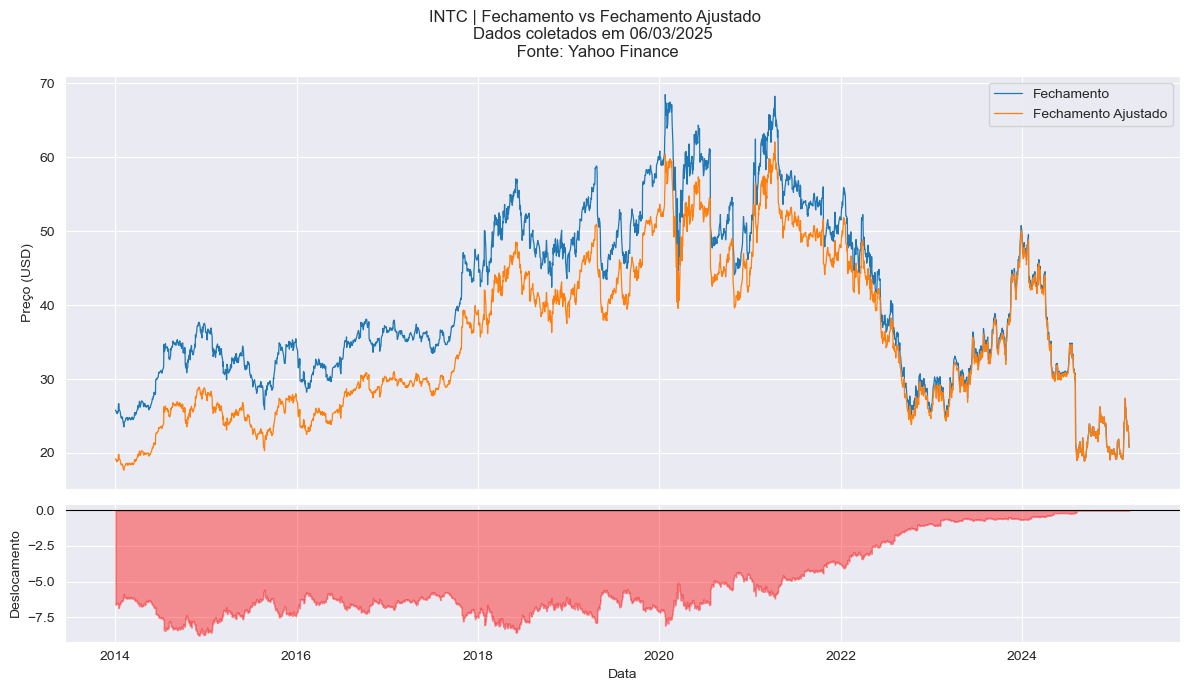

In [17]:
# 1. Prepara o DataFrame
df['Date'] = pd.to_datetime(df['Date'], utc=True)
df = df.sort_values('Date')
ticker = df['ticker_name'].iloc[0]

fig, (ax_price, ax_gap) = plt.subplots(
    2, 1, figsize=(12, 7), sharex=True,
    gridspec_kw={'height_ratios': [3, 1]}
)

# Painel 1 – preços
ax_price.plot(df['Date'], df['Close'], label='Fechamento', linewidth=0.9)
ax_price.plot(df['Date'], df['Adj Close'], label='Fechamento Ajustado', linewidth=0.9)
ax_price.set_ylabel('Preço (USD)')
ax_price.legend(loc='upper right')
ax_price.grid(True)

# Painel 2 – deslocamento
gap = df['Adj Close'] - df['Close']
ax_gap.fill_between(df['Date'], gap, 0, color='red', alpha=0.4, step='mid')
ax_gap.set_ylabel('Deslocamento')
ax_gap.set_xlabel('Data')
ax_gap.axhline(0, color='black', linewidth=0.8)
ax_gap.grid(True)

fig.suptitle(f'{ticker} | Fechamento vs Fechamento Ajustado\nDados coletados em 06/03/2025 \n Fonte: Yahoo Finance')
plt.tight_layout()
plt.show()